# Exploring the Blinkist dataset

This notebook represents a stream of consciousness as I explore to Blinkist dataset. 

It is not intended to represent formal analysis.

In [1]:
import altair as alt
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import kurtosis
from scipy.stats.mstats import winsorize

from IPython.display import Image 
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from six import StringIO
import pydotplus

import missingno as msno

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Subscribers who purchased between 2020-08-15 and 2020-09-14
# Sign-up → Start 7-day free trial → Retain after trial
df_subs = pd.read_csv("data/subscribers.csv")

df_books = pd.read_csv("data/books.csv")

# Raw user interactions with books during the 7-day trial + 30 days after the purchase. 
# Each row is a single continuous interaction with a book, 
    # with associated duration, numbers of chapters opened, timestamp, information about listening or reading the book, and the app screen from which the book was opened.
df_book_interactions = pd.read_csv("data/book_interactions.csv")

In [3]:
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18814 entries, 0 to 18813
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             18814 non-null  object
 1   signup_at           18814 non-null  object
 2   trial_optin_at      18814 non-null  object
 3   trial_retention_at  18814 non-null  object
dtypes: object(4)
memory usage: 588.1+ KB


In [4]:
df_subs["signup_at_ts"] = pd.to_datetime(df_subs.signup_at)
df_subs["trial_optin_at_ts"] = pd.to_datetime(df_subs.trial_optin_at)
df_subs["trial_retention_at_ts"] = pd.to_datetime(df_subs.trial_retention_at)

In [5]:
df_subs.describe()

<ipython-input-5-52e600e99464>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_subs.describe()
<ipython-input-5-52e600e99464>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_subs.describe()
<ipython-input-5-52e600e99464>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_subs.describe()


user_id            signup_at  \
count                      18814                18814   
unique                     18814                18752   
top     5f54279ed32d7a0012a39372  2020-09-02 15:41:08   
freq                           1                    2   
first                        NaN                  NaN   
last                         NaN                  NaN   

                 trial_optin_at   trial_retention_at         signup_at_ts  \
count                     18814                18814                18814   
unique                    18685                18752                18752   
top     2020-08-10 19:19:45.827  2020-08-30 16:31:03  2020-08-15 09:34:00   
freq                          3                    2                    2   
first                       NaN                  NaN  2018-12-15 07:34:33   
last                        NaN                  NaN  2020-10-22 13:38:10   

                 trial_optin_at_ts trial_retention_at_ts  
count                        18814                 18814  
unique                       18685                 18752  
top     2020-08-10 19:19:45.827000   2020-08-26 21:42:52  
freq                             3                     2  
first   2018-12-15 07:35:38.119000   2020-08-15 00:00:29  
last    2020-10-22 13:38:57.297000   2020-09-13 23:58:15

In [6]:
# not 100% clear what `trial_optin_at` represents
# time between `trial_optin_at` and `trial_retention_at` varies, not simply by a year, but all over the place
# dataset contains people who signed up in 2018 so this won't be their first annual subscription
df_subs.head(25)

user_id            signup_at           trial_optin_at  \
0   5c161baed32d7a00110d70f2  2018-12-16 09:32:30  2018-12-16 09:36:07.802   
1   5c50e3e9d32d7a0011ea78fa  2019-01-29 23:38:17  2019-01-29 23:40:04.367   
2   5c58e931d32d7a00108c2036  2019-02-05 01:38:57  2019-02-05 03:09:08.735   
3   5c64c1a1d32d7a0011928548  2019-02-14 01:17:21  2019-02-14 14:41:55.731   
4   5d31c8d0d32d7a0010fc9520  2019-07-19 13:42:40  2019-07-19 13:43:45.209   
5   5d6734e0d32d7a00121442ed  2019-08-29 02:13:52  2019-08-29 02:15:54.838   
6   5d6d6ae9d32d7a0012e7380d  2019-09-02 19:18:01  2019-09-02 19:19:30.467   
7   5d8f1d39d32d7a00114d5c03  2019-09-28 08:43:37  2019-09-28 08:44:42.795   
8   5da35fe1d32d7a0017bb7fc8  2019-10-13 17:33:21   2019-10-13 17:34:03.57   
9   5da3ade8d32d7a001456bbd4  2019-10-13 23:06:16  2019-10-13 23:07:35.529   
10  5db45ff9d32d7a0015bb2934  2019-10-26 15:02:17  2019-10-26 15:06:34.522   
11  5df056b6d32d7a001735fdde  2019-12-11 02:38:46  2019-12-11 02:40:09.786   
12  5dfc9166d32d7a00135dae41  2019-12-20 09:16:22  2019-12-20 09:17:04.586   
13  5e240363d32d7a0014678d8f  2020-01-19 07:21:07  2020-01-19 07:21:38.989   
14  5e5199d5d32d7a00144ab4ac  2020-02-22 21:15:01  2020-02-22 21:16:38.495   
15  5e92f66fd32d7a001762926a  2020-04-12 11:07:27  2020-04-12 11:07:56.616   
16  5e9610cfd32d7a00182b4a35  2020-04-14 19:36:47  2020-04-14 19:38:33.093   
17  5eaf490fd32d7a0017fcf175  2020-05-03 22:43:27  2020-05-03 22:45:30.176   
18  5eb888d0d32d7a000eab32bf  2020-05-10 23:05:52   2020-05-10 23:06:48.88   
19  5ec3e490d32d7a0017f52801  2020-05-19 13:52:16   2020-05-19 13:54:17.69   
20  5eda4ea3d32d7a0012ea3693  2020-06-05 13:54:43  2020-06-05 13:56:57.376   
21  5edb1dc3d32d7a000ea70f62  2020-06-06 04:38:27   2020-06-06 19:11:00.59   
22  5edcf344d32d7a000e64b497  2020-06-07 14:01:40  2020-06-07 14:06:23.317   
23  5ee7535fd32d7a000f196006  2020-06-15 10:54:23  2020-06-15 10:56:13.393   
24  5eebd1aed32d7a000e5d8009  2020-06-18 20:42:22  2020-06-18 20:43:37.713   

     trial_retention_at        signup_at_ts       trial_optin_at_ts  \
0   2020-08-16 07:14:45 2018-12-16 09:32:30 2018-12-16 09:36:07.802   
1   2020-08-16 22:55:24 2019-01-29 23:38:17 2019-01-29 23:40:04.367   
2   2020-09-11 12:57:38 2019-02-05 01:38:57 2019-02-05 03:09:08.735   
3   2020-08-20 01:42:41 2019-02-14 01:17:21 2019-02-14 14:41:55.731   
4   2020-09-10 12:02:34 2019-07-19 13:42:40 2019-07-19 13:43:45.209   
5   2020-08-29 04:33:46 2019-08-29 02:13:52 2019-08-29 02:15:54.838   
6   2020-08-23 16:38:18 2019-09-02 19:18:01 2019-09-02 19:19:30.467   
7   2020-08-20 21:11:22 2019-09-28 08:43:37 2019-09-28 08:44:42.795   
8   2020-09-08 07:30:59 2019-10-13 17:33:21 2019-10-13 17:34:03.570   
9   2020-09-06 14:55:01 2019-10-13 23:06:16 2019-10-13 23:07:35.529   
10  2020-08-24 14:21:06 2019-10-26 15:02:17 2019-10-26 15:06:34.522   
11  2020-08-23 00:34:27 2019-12-11 02:38:46 2019-12-11 02:40:09.786   
12  2020-08-27 17:21:02 2019-12-20 09:16:22 2019-12-20 09:17:04.586   
13  2020-08-19 15:04:18 2020-01-19 07:21:07 2020-01-19 07:21:38.989   
14  2020-09-05 23:08:19 2020-02-22 21:15:01 2020-02-22 21:16:38.495   
15  2020-08-18 14:11:46 2020-04-12 11:07:27 2020-04-12 11:07:56.616   
16  2020-09-02 16:34:36 2020-04-14 19:36:47 2020-04-14 19:38:33.093   
17  2020-08-19 05:32:16 2020-05-03 22:43:27 2020-05-03 22:45:30.176   
18  2020-08-28 00:12:59 2020-05-10 23:05:52 2020-05-10 23:06:48.880   
19  2020-08-21 00:54:46 2020-05-19 13:52:16 2020-05-19 13:54:17.690   
20  2020-08-29 16:01:45 2020-06-05 13:54:43 2020-06-05 13:56:57.376   
21  2020-08-29 14:53:20 2020-06-06 04:38:27 2020-06-06 19:11:00.590   
22  2020-09-03 18:41:40 2020-06-07 14:01:40 2020-06-07 14:06:23.317   
23  2020-08-23 21:41:53 2020-06-15 10:54:23 2020-06-15 10:56:13.393   
24  2020-08-27 20:40:25 2020-06-18 20:42:22 2020-06-18 20:43:37.713   

   trial_retention_at_ts  
0    2020-08-16 07:14:45  
1    2020-08-16 22:55:24  
2    2020-09-11 12:57:38  
3    2020-08-20 01:42:41  
4    2020-

In [7]:
df_subs["days_signup_to_trial"] = (df_subs.trial_optin_at_ts - df_subs.signup_at_ts)
df_subs.days_signup_to_trial = [i.days for i in df_subs.days_signup_to_trial]

df_subs["days_trial_to_retention"] = (df_subs.trial_retention_at_ts - df_subs.trial_optin_at_ts)
df_subs.days_trial_to_retention = [i.days for i in df_subs.days_trial_to_retention]

In [8]:
signup_to_trial_hist = df_subs.groupby("days_signup_to_trial").agg(customers=("user_id", "nunique")).reset_index()

In [9]:
alt.Chart(signup_to_trial_hist).mark_bar().encode(
    x="days_signup_to_trial",
    y="customers"
).properties(width=450)

alt.Chart(...)

Everyone selected their trial on the same day the signed up.

In [10]:
df_subs.drop(columns=["days_signup_to_trial"], inplace=True)

In [11]:
trial_to_retention_hist = df_subs.groupby("days_trial_to_retention").agg(customers=("user_id", "nunique")).reset_index()

In [12]:
alt.Chart(trial_to_retention_hist).mark_bar().encode(
    x="days_trial_to_retention",
    y="customers"
).properties(width=450)

alt.Chart(...)

In [13]:
alt.Chart(trial_to_retention_hist).mark_bar(clip=True).encode(
    x=alt.X("days_trial_to_retention:Q",
           scale=alt.Scale(domain=(0, 10))
    ),
    y="customers"
).properties(width=450)

alt.Chart(...)

In [14]:
calc = sum(trial_to_retention_hist[trial_to_retention_hist.days_trial_to_retention.isin([6, 7])].customers) / sum(trial_to_retention_hist.customers)

print(f"pc of customers that purchased 6 or 7 days after their trial started {round(calc, 2)*100}")

pc of customers that purchased 6 or 7 days after their trial started 88.0


In [15]:
df_book_interactions.shape

(391084, 10)

In [16]:
df_book_interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391084 entries, 0 to 391083
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   user_id               391084 non-null  object
 1   book_id               391084 non-null  object
 2   opened_at             391084 non-null  object
 3   opened_from           255342 non-null  object
 4   time_spent_in_book_s  391084 non-null  int64 
 5   chapters_opened       391084 non-null  int64 
 6   chapters_total        391084 non-null  int64 
 7   book_started          391084 non-null  bool  
 8   book_finished         391084 non-null  bool  
 9   audio_played          391084 non-null  bool  
dtypes: bool(3), int64(3), object(4)
memory usage: 22.0+ MB


In [17]:
df_book_interactions["time_spent_in_book_m"] = df_book_interactions.time_spent_in_book_s / 60
df_book_interactions["opened_at_ds"] = pd.to_datetime(df_book_interactions.opened_at)

In [18]:
# would have expected this dataset to contain more people with book interactions than subscribers
# as we want to view the difference of those that retained versus those that didn't
df_book_interactions.user_id.nunique(), df_subs.user_id.nunique()

(14329, 18814)

In [19]:
# all those who interacted with a book also subscribed
np.unique(np.in1d(df_book_interactions.user_id.unique(), df_subs.user_id.unique()))

array([ True])

In [20]:
df_book_interactions.opened_from.value_counts()

flex-discover    162076
search            74423
reader            17916
deeplink            882
minute               45
Name: opened_from, dtype: int64

In [21]:
# pc missing from opened from
calc = (df_book_interactions.shape[0] - sum(df_book_interactions.opened_from.notna())) / df_book_interactions.shape[0]

print(f"pc of rows missing `opened_from`: {round(calc, 2)*100}")

pc of rows missing `opened_from`: 35.0


In [22]:
# could do forward fill
# if `open_from` not null on the same day then fill

In [23]:
df_book_interactions.describe()

time_spent_in_book_s  chapters_opened  chapters_total  \
count         391084.000000    391084.000000   391084.000000   
mean             537.134091         4.866172        9.986417   
std              546.821317         3.616569        1.870332   
min                0.000000         1.000000        3.000000   
25%               36.000000         1.000000        9.000000   
50%              367.000000         4.000000       10.000000   
75%              935.000000         8.000000       11.000000   
max             9787.000000        18.000000       18.000000   

       time_spent_in_book_m  
count         391084.000000  
mean               8.952235  
std                9.113689  
min                0.000000  
25%                0.600000  
50%                6.116667  
75%               15.583333  
max              163.116667

In [24]:
df_book_interactions.user_id.describe()

count                       391084
unique                       14329
top       5f4d3d0ad32d7a001079c4a3
freq                          1145
Name: user_id, dtype: object

In [25]:
# some books have no interaction, but fine to inner join
df_book_interactions.book_id.nunique(), df_books.book_id.nunique()

(4241, 4407)

In [26]:
df_base = pd.merge(df_book_interactions, df_books, on="book_id")

In [27]:
# each row is single interaction with book 
# but users might go from one book to the next
# do i want to create a column for days active or create a notion of "sessions"?

df_base[df_base.user_id == "5f4d3d0ad32d7a001079c4a3"].sort_values(by=["opened_at"])

user_id                   book_id   opened_at  \
331868  5f4d3d0ad32d7a001079c4a3  5a098a54b238e1000655ceef  2020-09-01   
162457  5f4d3d0ad32d7a001079c4a3  5eff36356cee070006b9c3a5  2020-09-01   
162458  5f4d3d0ad32d7a001079c4a3  5eff36356cee070006b9c3a5  2020-09-01   
24788   5f4d3d0ad32d7a001079c4a3  5d4bd6e76cee070007daac1f  2020-09-01   
317786  5f4d3d0ad32d7a001079c4a3  5b5e6d19b238e10007a4bba1  2020-09-01   
...                          ...                       ...         ...   
103736  5f4d3d0ad32d7a001079c4a3  59c8fcbab238e10005c201d7  2020-10-07   
143589  5f4d3d0ad32d7a001079c4a3  5ee390fb6cee070006837810  2020-10-07   
386994  5f4d3d0ad32d7a001079c4a3  56f3b87e2bf5b9000700003b  2020-10-07   
386234  5f4d3d0ad32d7a001079c4a3  555b3bd56135330007ae0000  2020-10-07   
143590  5f4d3d0ad32d7a001079c4a3  5ee390fb6cee070006837810  2020-10-07   

          opened_from  time_spent_in_book_s  chapters_opened  chapters_total  \
331868            NaN                  1060                9               9   
162457            NaN                   988                7               8   
162458            NaN                   200                2               8   
24788             NaN                   752                9              10   
317786            NaN                  1243                9               9   
...               ...                   ...              ...             ...   
103736  flex-discover                   834                8               8   
143589            NaN                  1862               11              11   
386994            NaN                   167                3               8   
386234            NaN                  1120               11              11   
143590            NaN                     3                1              11   

        book_started  book_finished  audio_played  time_spent_in_book_m  \
331868          True           True          True             17.666667   
162457         False           True          True             16.466667   
162458          True          False          True              3.333333   
24788           True           True          True             12.533333   
317786          True           True          True             20.716667   
...              ...            ...           ...                   ...   
103736          True           True          True             13.900000   
143589          True           True          True             31.033333   
386994          True          False          True              2.783333   
386234          True           True          True             18.666667   
143590         False           True          True              0.050000   

       opened_at_ds                                              title  \
331868   2020-09-01                                      Joy on Demand   
162457   2020-09-01                             Charismatic Leadership   
162458   2020-09-01                             Charismatic Leadership   
24788    2020-09-01                        A Monk's Guide to Happiness   
317786   2020-09-01                                        Mindfulness   
...             ...                                                ...   
103736   2020-10-07  What They Don’t Teach You at Harvard Business ...   
143589   2020-10-07                                  Mere Christianity   
386994   2020-10-07                                             Rocket   
386234   2020-10-07                                          Evergreen   
143590   2020-10-07                                  Mere Christianity   

                                                   author  \
331868                                     Chade-Meng Tan   
162457                                       Kevin Murray   
162458                                       Kevin Murray   
24788                                      Gelong Thubten   
317786                     Mark Williams and Danny Penman   
...                

In [28]:
# most extreme case, one user, lots of books
df_base[(df_base.user_id == "5f4d3d0ad32d7a001079c4a3") & (df_base.opened_at == "2020-09-01")].sort_values(by=["opened_at"])

user_id                   book_id   opened_at  \
7756    5f4d3d0ad32d7a001079c4a3  5eff3e536cee070006112e48  2020-09-01   
365639  5f4d3d0ad32d7a001079c4a3  5bb5c7f5862c430007d26da9  2020-09-01   
331868  5f4d3d0ad32d7a001079c4a3  5a098a54b238e1000655ceef  2020-09-01   
317786  5f4d3d0ad32d7a001079c4a3  5b5e6d19b238e10007a4bba1  2020-09-01   
306759  5f4d3d0ad32d7a001079c4a3  5a516061b238e10006337079  2020-09-01   
306585  5f4d3d0ad32d7a001079c4a3  5460dd3331363000088e0000  2020-09-01   
305873  5f4d3d0ad32d7a001079c4a3  5ade2852b238e10007596e7e  2020-09-01   
305252  5f4d3d0ad32d7a001079c4a3  59ad8338b238e10005ef001c  2020-09-01   
303116  5f4d3d0ad32d7a001079c4a3  5623b0983264660007040000  2020-09-01   
297841  5f4d3d0ad32d7a001079c4a3  54a987926233320009100000  2020-09-01   
252320  5f4d3d0ad32d7a001079c4a3  5e7e1f6d6cee07000723f87f  2020-09-01   
244040  5f4d3d0ad32d7a001079c4a3  5a65b8adb238e10007b0ca10  2020-09-01   
241146  5f4d3d0ad32d7a001079c4a3  566610d5cb2fee0007000023  2020-09-01   
239780  5f4d3d0ad32d7a001079c4a3  55f6ea9f29161a0009000114  2020-09-01   
239248  5f4d3d0ad32d7a001079c4a3  5678651d0bac9b000700000b  2020-09-01   
377094  5f4d3d0ad32d7a001079c4a3  581da3167882c20003e52c57  2020-09-01   
214351  5f4d3d0ad32d7a001079c4a3  55ae019b3366610007000000  2020-09-01   
213696  5f4d3d0ad32d7a001079c4a3  53eb4a1436343300077d0000  2020-09-01   
185826  5f4d3d0ad32d7a001079c4a3  5d210d886cee07000704d9b7  2020-09-01   
164185  5f4d3d0ad32d7a001079c4a3  5f35ac246cee07000600527a  2020-09-01   
164184  5f4d3d0ad32d7a001079c4a3  5f35ac246cee07000600527a  2020-09-01   
162458  5f4d3d0ad32d7a001079c4a3  5eff36356cee070006b9c3a5  2020-09-01   
162457  5f4d3d0ad32d7a001079c4a3  5eff36356cee070006b9c3a5  2020-09-01   
84824   5f4d3d0ad32d7a001079c4a3  52fa3823666261000c0a0000  2020-09-01   
84447   5f4d3d0ad32d7a001079c4a3  55fffd1d615cd1000900009e  2020-09-01   
50584   5f4d3d0ad32d7a001079c4a3  59f5e58eb238e10006f6076f  2020-09-01   
41106   5f4d3d0ad32d7a001079c4a3  5bc87a636cee070007cc73be  2020-09-01   
38859   5f4d3d0ad32d7a001079c4a3  5c1eb6276cee070008e79f42  2020-09-01   
35882   5f4d3d0ad32d7a001079c4a3  5c49dafd6cee070007b962a4  2020-09-01   
34436   5f4d3d0ad32d7a001079c4a3  5c6a72716cee070007fe684d  2020-09-01   
24788   5f4d3d0ad32d7a001079c4a3  5d4bd6e76cee070007daac1f  2020-09-01   
214166  5f4d3d0ad32d7a001079c4a3  5820ea7a4d1bae00032dc442  2020-09-01   
379774  5f4d3d0ad32d7a001079c4a3  57d65c6b08c9270003b191be  2020-09-01   

          opened_from  time_spent_in_book_s  chapters_opened  chapters_total  \
7756              NaN                  1622               11              11   
365639            NaN                  1247               10              10   
331868            NaN                  1060                9               9   
317786            NaN                  1243                9               9   
306759            NaN                   829                8               8   
306585            NaN                  1035                9               9   
305873            NaN                  1236               10              10   
305252            NaN                  1080               10              10   
303116            NaN                   883                8               8   
297841            NaN                    42                2              10   
252320            NaN                  1492               11              11   
244040            NaN                  1158                9               9   
241146            NaN                  1043               10              10   
239780            NaN                   945                9               9   
239248            NaN                  1086                9               9   
377094            NaN                   562                6               6   
214351            NaN                   641                7               7   
213696            NaN                  1337               11        

In [29]:
df_user_daily = df_base.copy()
df_user_daily = df_user_daily.groupby(["user_id", "opened_at", "opened_at_ds"]).agg(
    time_spent_in_book_s=("time_spent_in_book_s", sum),
    time_spent_in_book_m=("time_spent_in_book_m", sum),
    chapters_opened=("chapters_opened", sum),
    chapters_total=("chapters_total", sum),
    categories=("categories", "nunique"),
    books=("title", "nunique"),
    surfaces=("opened_from", "nunique"),    
).reset_index()

In [30]:
df_user_daily = pd.merge(df_subs, df_user_daily, on="user_id", how="left")

In [31]:
df_user_daily["days_since_signup"] = (df_user_daily.opened_at_ds - df_user_daily.signup_at_ts)
df_user_daily["days_since_signup"] = [i.days for i in df_user_daily.days_since_signup]

# df_user_daily["days_since_trial"] , not required as == signup

df_user_daily["days_since_trial_retention"] = (df_user_daily.opened_at_ds - df_user_daily.trial_retention_at_ts)
df_user_daily["days_since_trial_retention"] = [i.days for i in df_user_daily.days_since_trial_retention]

In [32]:
df_user_daily["avg_min_per_book"] = df_user_daily.books / df_user_daily.time_spent_in_book_m

In [33]:
df_user_daily["pc_book_complete"] = round(df_user_daily.chapters_opened / df_user_daily.chapters_total,2)

In [34]:
df_user_daily.head()

user_id            signup_at           trial_optin_at  \
0  5c161baed32d7a00110d70f2  2018-12-16 09:32:30  2018-12-16 09:36:07.802   
1  5c161baed32d7a00110d70f2  2018-12-16 09:32:30  2018-12-16 09:36:07.802   
2  5c161baed32d7a00110d70f2  2018-12-16 09:32:30  2018-12-16 09:36:07.802   
3  5c161baed32d7a00110d70f2  2018-12-16 09:32:30  2018-12-16 09:36:07.802   
4  5c161baed32d7a00110d70f2  2018-12-16 09:32:30  2018-12-16 09:36:07.802   

    trial_retention_at        signup_at_ts       trial_optin_at_ts  \
0  2020-08-16 07:14:45 2018-12-16 09:32:30 2018-12-16 09:36:07.802   
1  2020-08-16 07:14:45 2018-12-16 09:32:30 2018-12-16 09:36:07.802   
2  2020-08-16 07:14:45 2018-12-16 09:32:30 2018-12-16 09:36:07.802   
3  2020-08-16 07:14:45 2018-12-16 09:32:30 2018-12-16 09:36:07.802   
4  2020-08-16 07:14:45 2018-12-16 09:32:30 2018-12-16 09:36:07.802   

  trial_retention_at_ts  days_trial_to_retention   opened_at opened_at_ds  \
0   2020-08-16 07:14:45                      608  2018-12-17   2018-12-17   
1   2020-08-16 07:14:45                      608  2018-12-18   2018-12-18   
2   2020-08-16 07:14:45                      608  2018-12-19   2018-12-19   
3   2020-08-16 07:14:45                      608  2018-12-20   2018-12-20   
4   2020-08-16 07:14:45                      608  2020-08-16   2020-08-16   

   ...  time_spent_in_book_m  chapters_opened  chapters_total  categories  \
0  ...             69.733333             32.0            62.0         4.0   
1  ...            127.450000             55.0           101.0         6.0   
2  ...            169.366667             77.0           196.0        11.0   
3  ...            195.783333             82.0           202.0        10.0   
4  ...              8.400000              9.0            35.0         3.0   

   books  surfaces  days_since_signup  days_since_trial_retention  \
0    4.0       1.0                0.0                      -609.0   
1    6.0       2.0                1.0                      -608.0   
2   11.0       2.0                2.0                      -607.0   
3   10.0       1.0                3.0                      -606.0   
4    4.0       1.0              608.0                        -1.0   

   avg_min_per_book  pc_book_complete  
0          0.057361              0.52  
1          0.047077              0.54  
2          0.064948              0.39  
3          0.051077              0.41  
4          0.476190              0.26  

[5 rows x 21 columns]

In [35]:
# filtering on the 88% of people that retained 6/7 days after trial

df_ud = df_user_daily.copy()
df_ud = df_ud[df_ud.days_trial_to_retention.isin([6, 7])]

In [36]:
df_ud.head()

user_id            signup_at           trial_optin_at  \
682  5f2dd101d32d7a001484a82b  2020-08-07 22:09:05  2020-08-07 22:10:25.425   
683  5f2dd101d32d7a001484a82b  2020-08-07 22:09:05  2020-08-07 22:10:25.425   
684  5f2dd101d32d7a001484a82b  2020-08-07 22:09:05  2020-08-07 22:10:25.425   
685  5f2dd101d32d7a001484a82b  2020-08-07 22:09:05  2020-08-07 22:10:25.425   
691  5f2df61fd32d7a00147b501e  2020-08-08 00:47:27  2020-08-08 00:47:56.444   

      trial_retention_at        signup_at_ts       trial_optin_at_ts  \
682  2020-08-15 00:14:46 2020-08-07 22:09:05 2020-08-07 22:10:25.425   
683  2020-08-15 00:14:46 2020-08-07 22:09:05 2020-08-07 22:10:25.425   
684  2020-08-15 00:14:46 2020-08-07 22:09:05 2020-08-07 22:10:25.425   
685  2020-08-15 00:14:46 2020-08-07 22:09:05 2020-08-07 22:10:25.425   
691  2020-08-15 00:47:54 2020-08-08 00:47:27 2020-08-08 00:47:56.444   

    trial_retention_at_ts  days_trial_to_retention   opened_at opened_at_ds  \
682   2020-08-15 00:14:46                        7  2020-08-08   2020-08-08   
683   2020-08-15 00:14:46                        7  2020-08-17   2020-08-17   
684   2020-08-15 00:14:46                        7  2020-08-18   2020-08-18   
685   2020-08-15 00:14:46                        7  2020-09-11   2020-09-11   
691   2020-08-15 00:47:54                        6  2020-08-10   2020-08-10   

     ...  time_spent_in_book_m  chapters_opened  chapters_total  categories  \
682  ...              9.000000              5.0             8.0         1.0   
683  ...             37.866667             18.0            44.0         4.0   
684  ...             28.966667             14.0            18.0         2.0   
685  ...             13.833333              9.0            16.0         2.0   
691  ...              0.083333              1.0            10.0         1.0   

     books  surfaces  days_since_signup  days_since_trial_retention  \
682    1.0       1.0                0.0                        -8.0   
683    4.0       2.0                9.0                         1.0   
684    2.0       2.0               10.0                         2.0   
685    2.0       2.0               34.0                        26.0   
691    1.0       1.0                1.0                        -6.0   

     avg_min_per_book  pc_book_complete  
682          0.111111              0.62  
683          0.105634              0.41  
684          0.069045              0.78  
685          0.144578              0.56  
691         12.000000              0.10  

[5 rows x 21 columns]

In [37]:
# people's first 28 days after signing up
df_f28d = df_ud.copy()
df_f28d = df_f28d[df_f28d.days_since_signup <= 28]

df_f28d_active = df_f28d.groupby(["user_id"]).agg(
    days_active=("opened_at", "nunique")   
).reset_index()

# people's first 28 days after retention
df_r28d = df_ud.copy()
df_r28d = df_r28d[(df_r28d.days_since_trial_retention >= 0) & (df_r28d.days_since_trial_retention <= 28)]

df_r28d_active = df_r28d.groupby(["user_id"]).agg(
    days_active=("opened_at", "nunique")   
).reset_index()

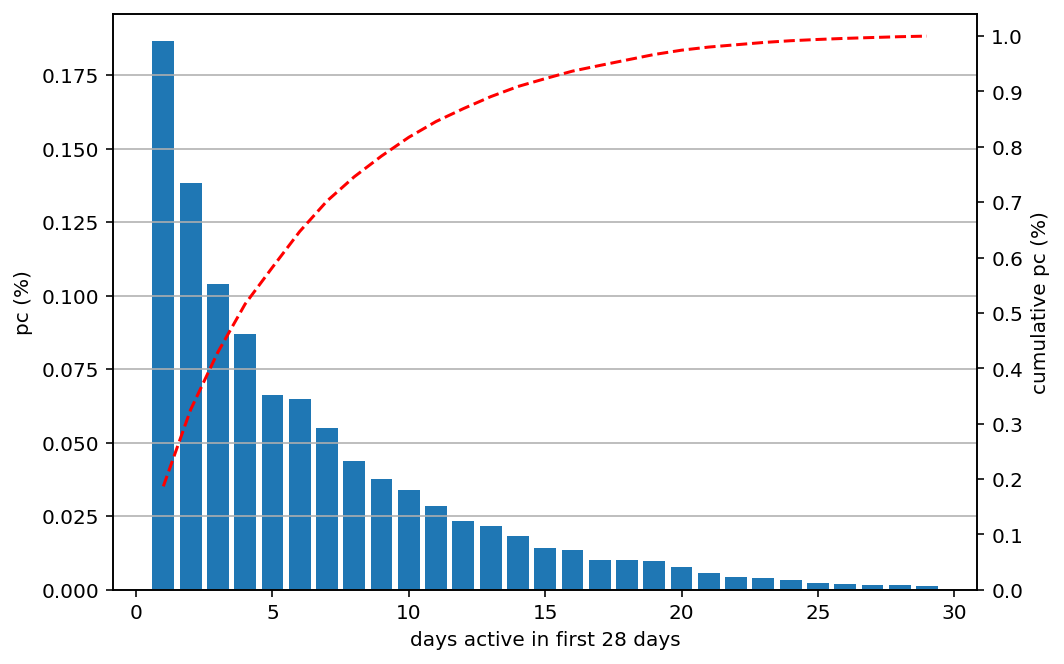

In [38]:
f28d_active = list(df_f28d_active.days_active.value_counts(normalize=True))

f28d_active_cumsum = [sum(f28d_active[:i[0] + 1]) for i in enumerate(f28d_active)]

x = sorted(df_f28d_active.days_active.unique())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()

ax.bar(x, f28d_active)
ax.set_ylabel('pc (%)')
ax.set_xlabel('days active in first 28 days')

ax2=ax.twinx()
ax2.plot(x, f28d_active_cumsum, 'r--')
ax2.set_yticks(np.arange(0.0, 1.1, 0.1))
ax2.set_ylabel('cumulative pc (%)')

plt.savefig("md_refs/first28d_active.png", dpi=300, format="png")
plt.show();

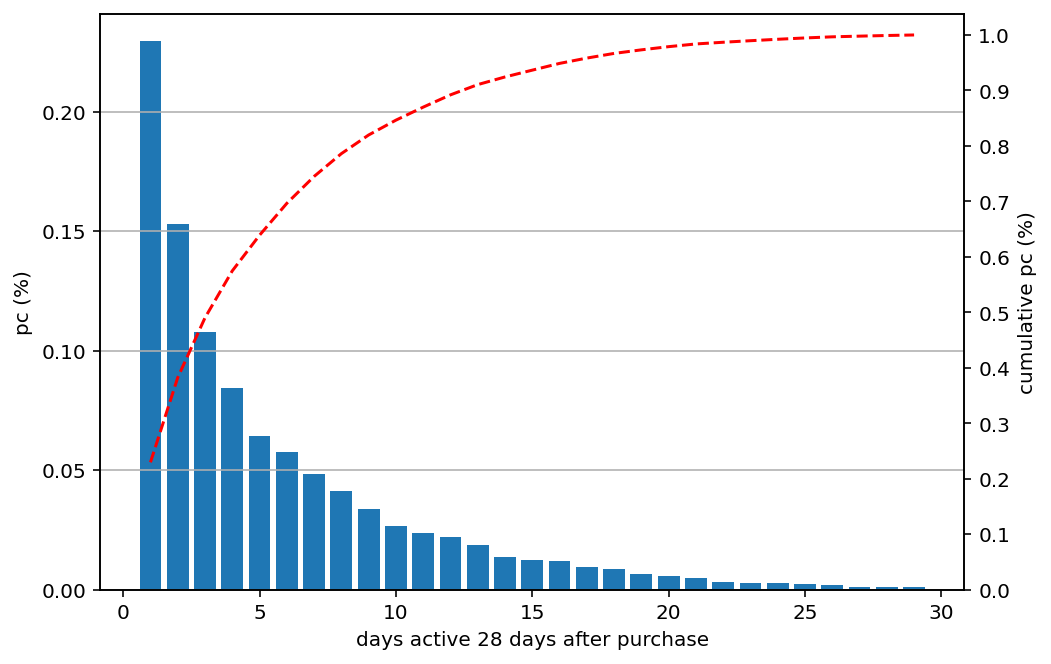

In [39]:
r28d_active = list(df_r28d_active.days_active.value_counts(normalize=True))

r28d_active_cumsum = [sum(r28d_active[:i[0] + 1]) for i in enumerate(r28d_active)]

x = sorted(df_r28d_active.days_active.unique())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()

ax.bar(x, r28d_active)
ax.set_ylabel('pc (%)')
ax.set_xlabel('days active 28 days after purchase')

ax2=ax.twinx()
ax2.plot(x, r28d_active_cumsum, 'r--')
ax2.set_yticks(np.arange(0.0, 1.1, 0.1))
ax2.set_ylabel('cumulative pc (%)')

plt.show()

In [40]:
print(f"""
Active one day: First 28 days {round(f28d_active_cumsum[0]*100)}%, 28 days post purchase {round(r28d_active_cumsum[0]*100)}%\n
Active four days: First 28 days {round(f28d_active[3]*100)}%, 28 days post purchase {round(r28d_active[3]*100)}%\n
Active four days or less: First 28 days {round(f28d_active_cumsum[3]*100)}%, 28 days post purchase {round(r28d_active_cumsum[3]*100)}%\n
Active at least 5 days: First 28 days {round(sum(f28d_active[4:])*100)}%, 28 days post purchase {round(sum(r28d_active[4:])*100)}%\n
Active at least 15 days: First 28 days {round(sum(f28d_active[14:])*100)}%, 28 days post purchase {round(sum(r28d_active[14:])*100)}%
""")


Active one day: First 28 days 19%, 28 days post purchase 23%

Active four days: First 28 days 9%, 28 days post purchase 8%

Active four days or less: First 28 days 52%, 28 days post purchase 57%

Active at least 5 days: First 28 days 48%, 28 days post purchase 43%

Active at least 15 days: First 28 days 9%, 28 days post purchase 8%



In [41]:
# people's first 7 days after signing up
df_f7d = df_ud.copy()
df_f7d = df_f7d[df_f7d.days_since_signup <= 7]

df_f7d_active = df_f7d.groupby(["user_id"]).agg(
    days_active=("opened_at", "nunique")   
).reset_index()

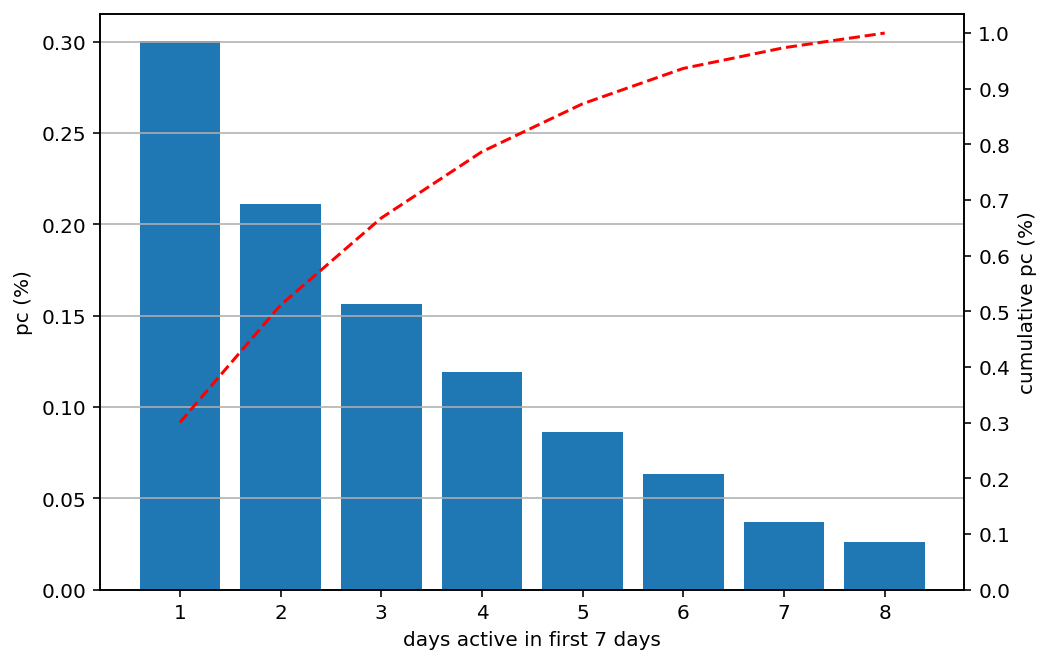

In [42]:
f7d_active = list(df_f7d_active.days_active.value_counts(normalize=True))

f7d_active_cumsum = [sum(f7d_active[:i[0] + 1]) for i in enumerate(f7d_active)]

x = sorted(df_f7d_active.days_active.unique())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()

ax.bar(x, f7d_active)
ax.set_ylabel('pc (%)')
ax.set_xlabel('days active in first 7 days')

ax2=ax.twinx()
ax2.plot(x, f7d_active_cumsum, 'r--')
ax2.set_yticks(np.arange(0.0, 1.1, 0.1))
ax2.set_ylabel('cumulative pc (%)')

# plt.savefig("md_refs/first7d_active.png", dpi=300, format="png")
plt.show();

In [43]:
print(f"""
Active at least 5 days: First 7 days {round(sum(f7d_active[4:])*100)}%
""")


Active at least 5 days: First 7 days 21%



In [44]:
# looking at first 28 days versus 28 days after paid

In [45]:
def agg_stats(df_subs: pd.DataFrame, df_daily: pd.DataFrame, filter_col, start=0, stop=28) -> pd.DataFrame:
    df = pd.merge(df_subs, df_daily, on="user_id", how="left")

    df["days_since_signup"] = (df.opened_at_ds - df.signup_at_ts)
    df["days_since_signup"] = [i.days for i in df.days_since_signup]

    df["days_since_trial_retention"] = (df.opened_at_ds - df.trial_retention_at_ts)
    df["days_since_trial_retention"] = [i.days for i in df.days_since_trial_retention]

    # keep the 88% of cases that make sense
    df = df[df.days_trial_to_retention.isin([6, 7])]

    df = df[(df[filter_col] >= start) & (df[filter_col] <= stop)]

    df = df.groupby(["user_id"]).agg(
        time_spent_in_book_s=("time_spent_in_book_s", sum),
        time_spent_in_book_m=("time_spent_in_book_m", sum),
        chapters_opened=("chapters_opened", sum),
        chapters_total=("chapters_total", sum),
        categories=("categories", "nunique"),
        books=("title", "nunique"),
        surfaces=("opened_from", "nunique"),    
        days_active=("opened_at_ds", "nunique"),    
    ).reset_index()

    df["avg_min_per_book"] =  df.time_spent_in_book_m / df.books
    df["avg_min_per_day"] =  df.time_spent_in_book_m / df.days_active
    df["chapters_per_book"] =  df.chapters_opened / df.books    
    df["books_per_day"] =  df.books / df.days_active    
    df["books_per_category"] =  df.books / df.categories    

    df["pc_books_complete"] = round(df.chapters_opened / df.chapters_total,2)*100

    return df

In [46]:
df_f28d_stats = agg_stats(df_subs, df_base, "days_since_signup")
df_r28d_stats = agg_stats(df_subs, df_base, "days_since_trial_retention")

In [47]:
df_f28d_stats.shape[0], df_r28d_stats.shape[0]

(12232, 10436)

In [48]:
df_prod_use = pd.merge(df_f28d_stats, df_r28d_stats, how="left", on="user_id", suffixes=("_f28d", "_r28d"))

In [49]:
comparison_stats = df_f28d_stats.columns[2:].values
comparison_stats = np.delete(comparison_stats, 2)  # remove chapters total

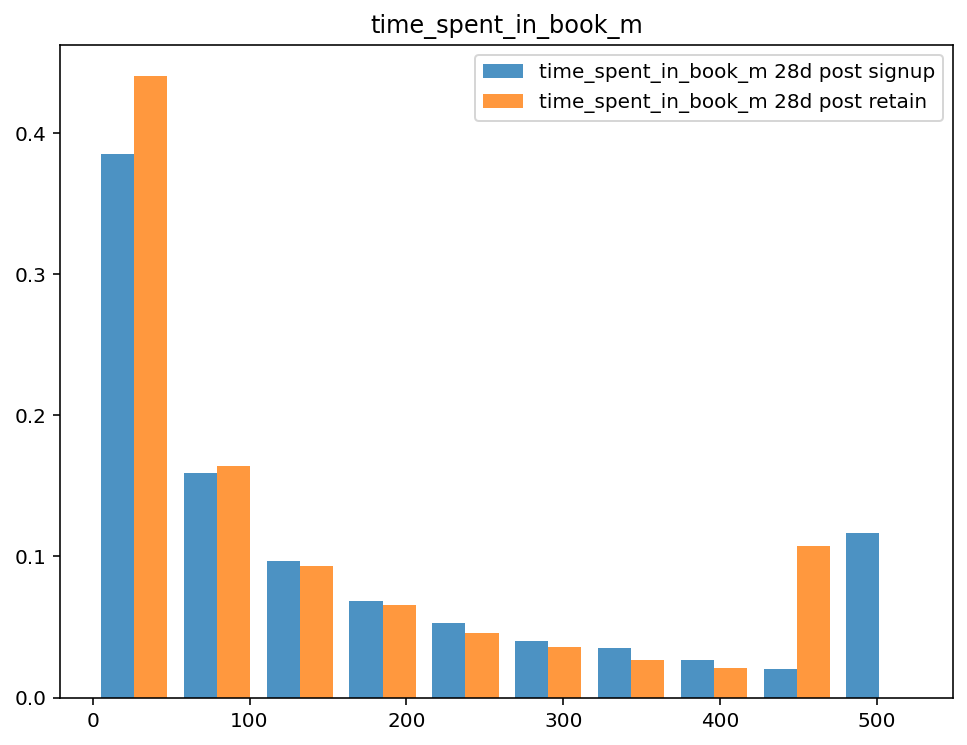

Average time_spent_in_book_m 28d post signup 161, 28d post retain 132



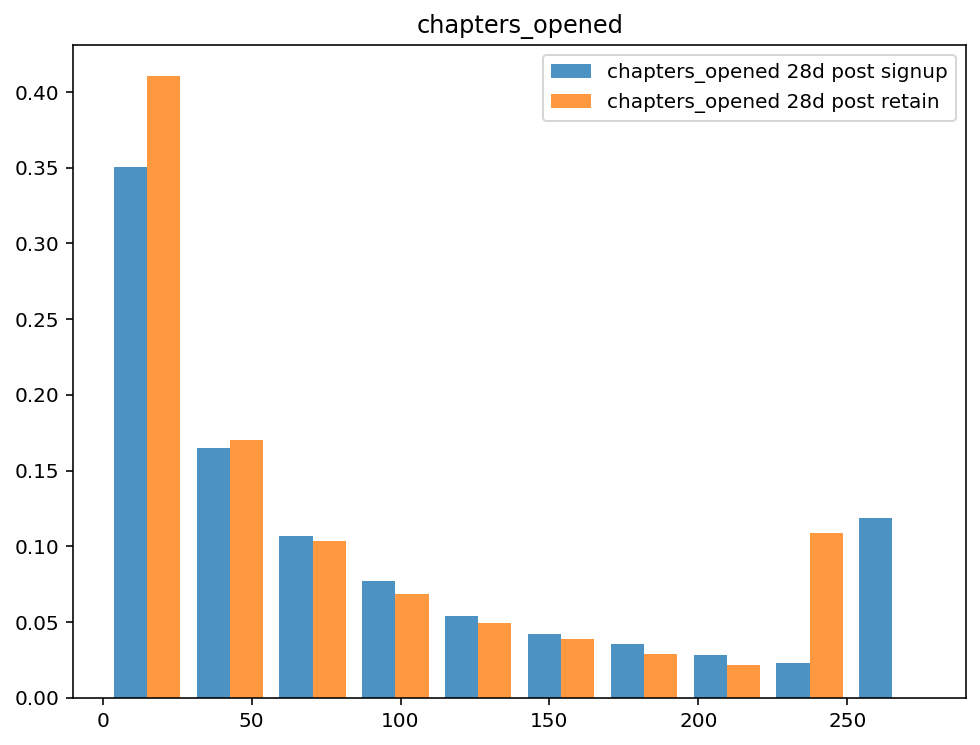

Average chapters_opened 28d post signup 90, 28d post retain 73



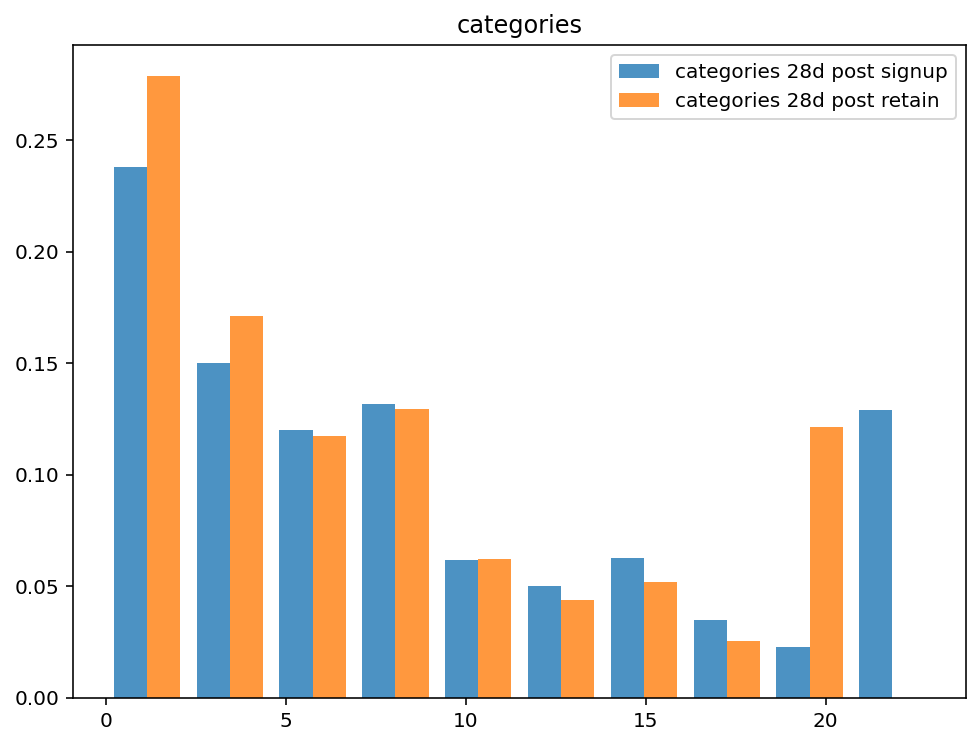

Average categories 28d post signup 9, 28d post retain 7



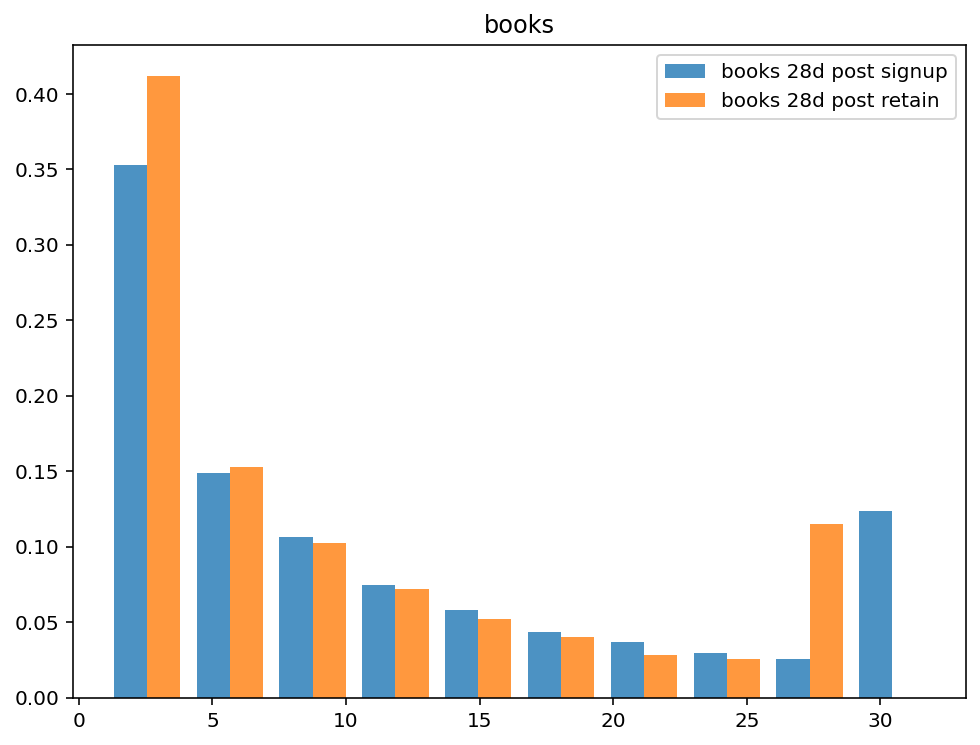

Average books 28d post signup 11, 28d post retain 9



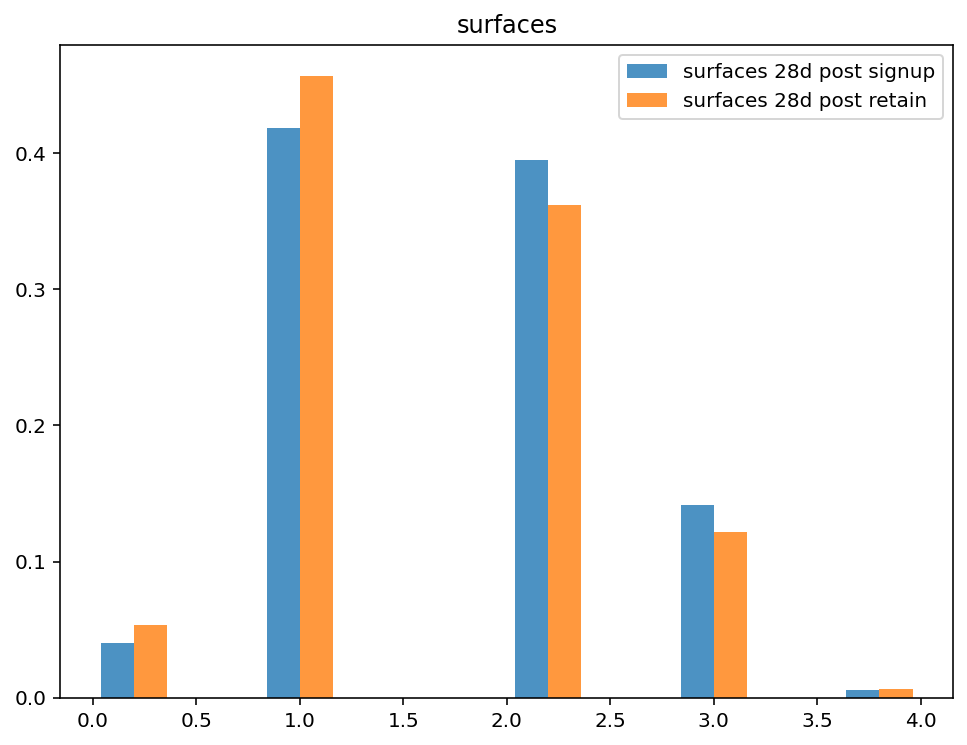

Average surfaces 28d post signup 2, 28d post retain 2



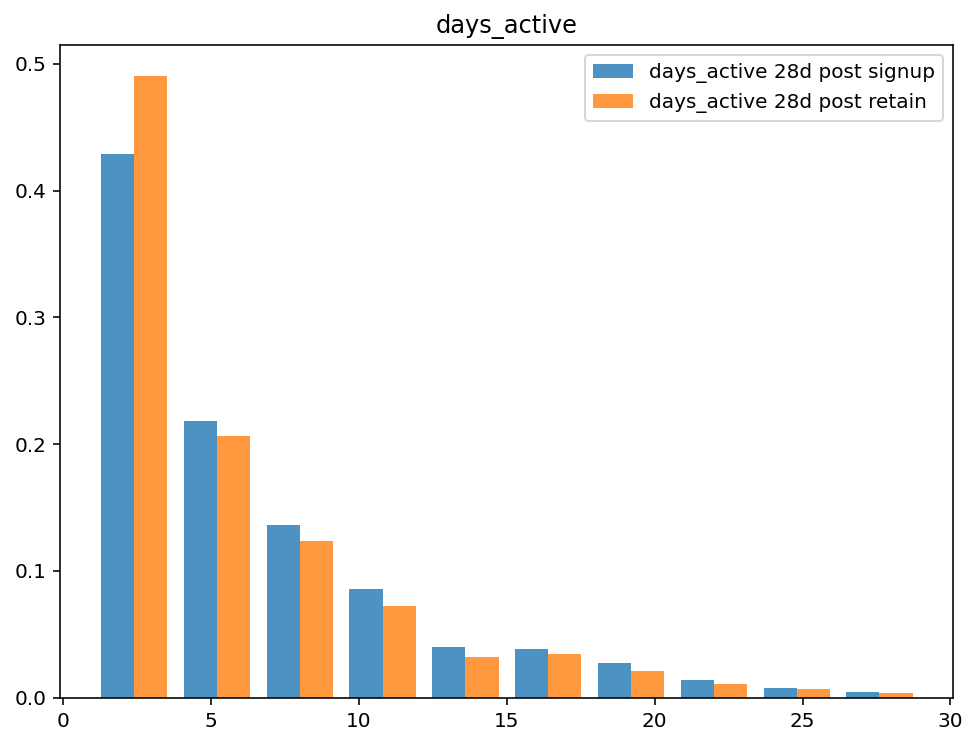

Average days_active 28d post signup 6, 28d post retain 5



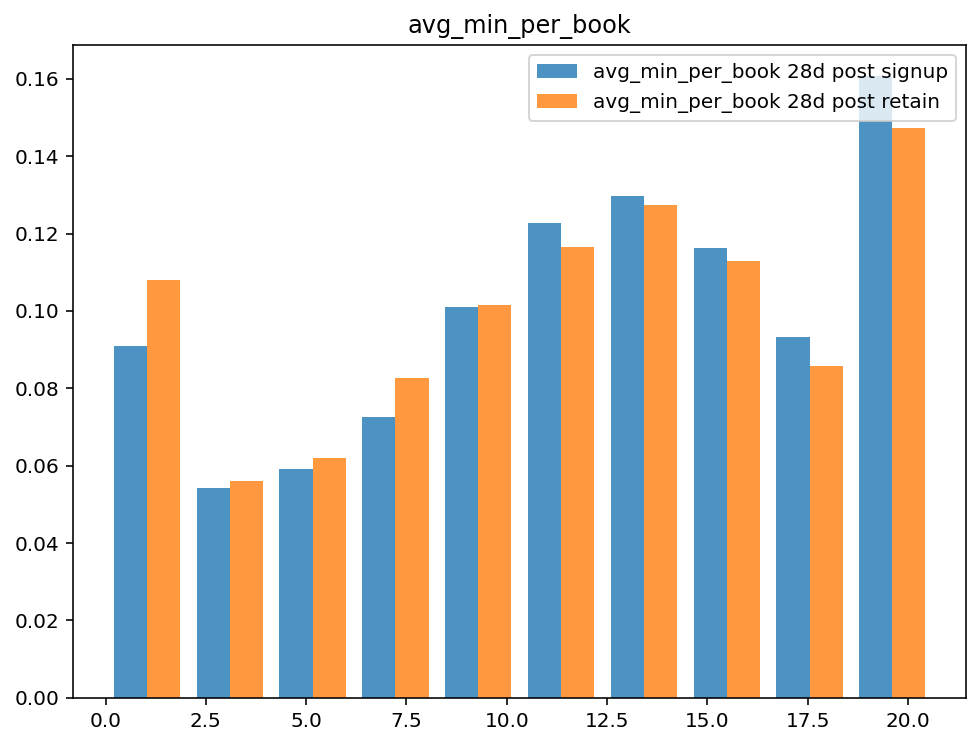

Average avg_min_per_book 28d post signup 12, 28d post retain 11



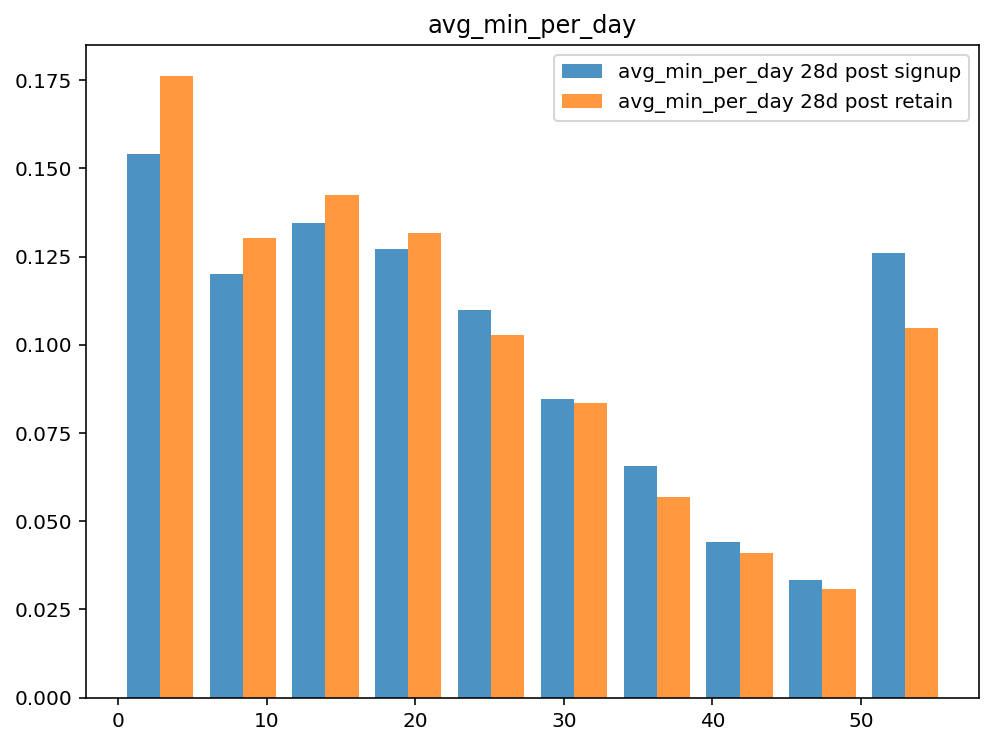

Average avg_min_per_day 28d post signup 24, 28d post retain 22



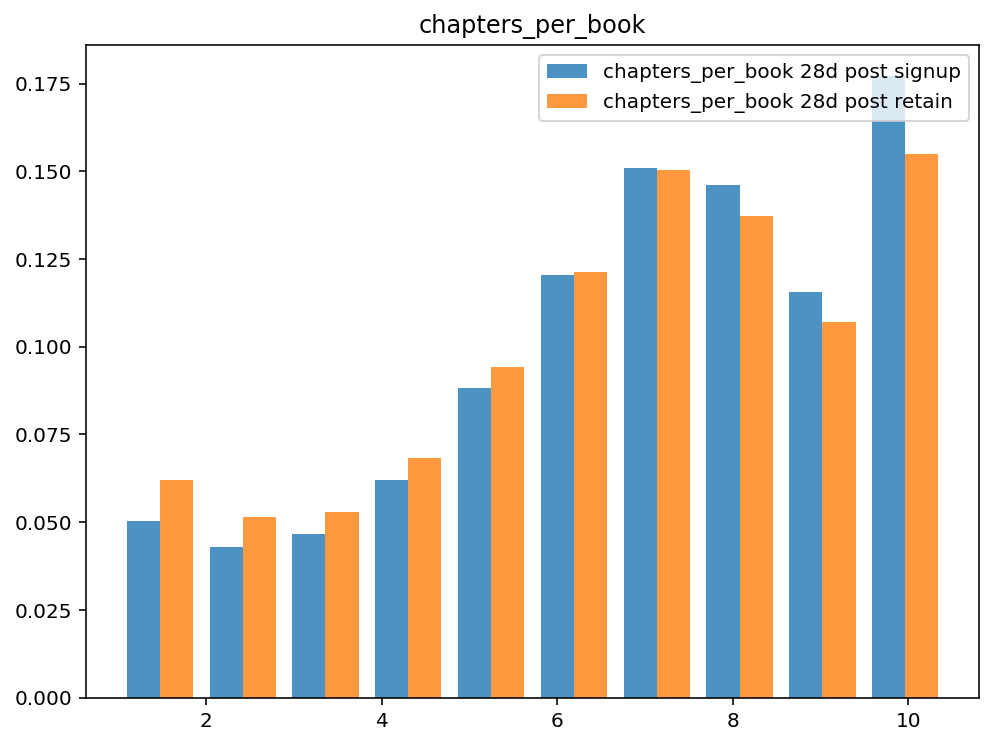

Average chapters_per_book 28d post signup 7, 28d post retain 7



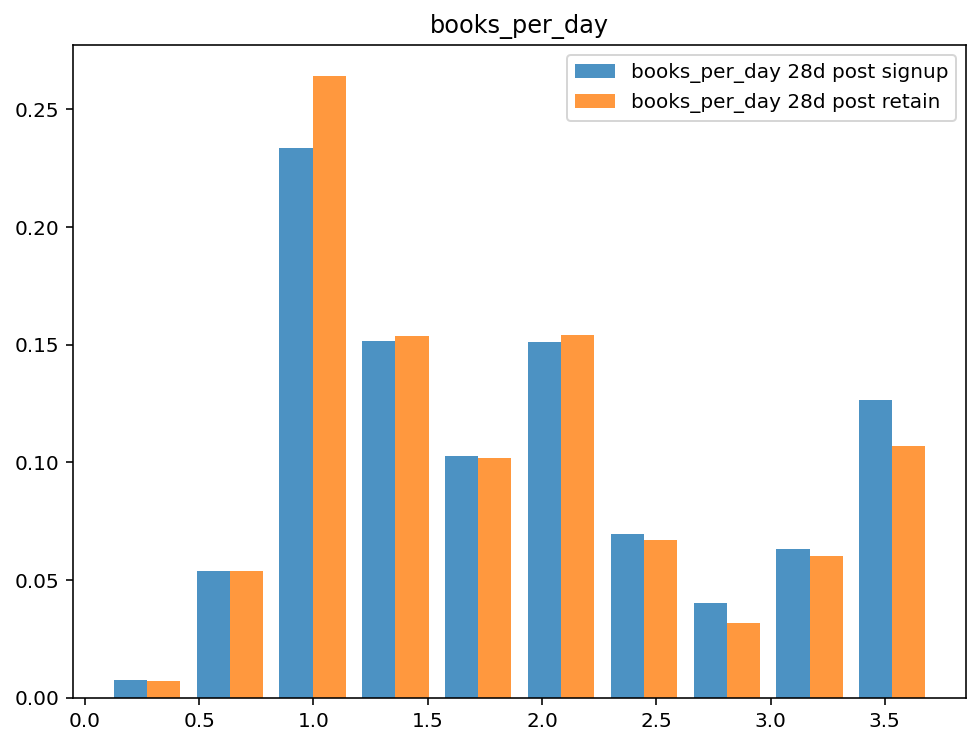

Average books_per_day 28d post signup 2, 28d post retain 2



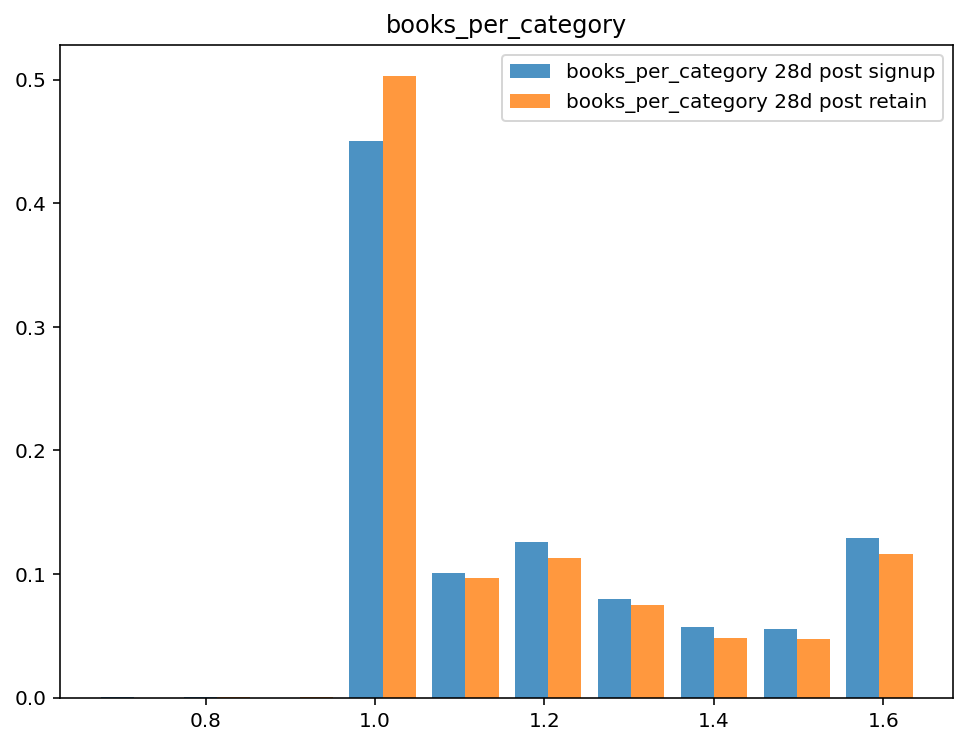

Average books_per_category 28d post signup 1, 28d post retain 1



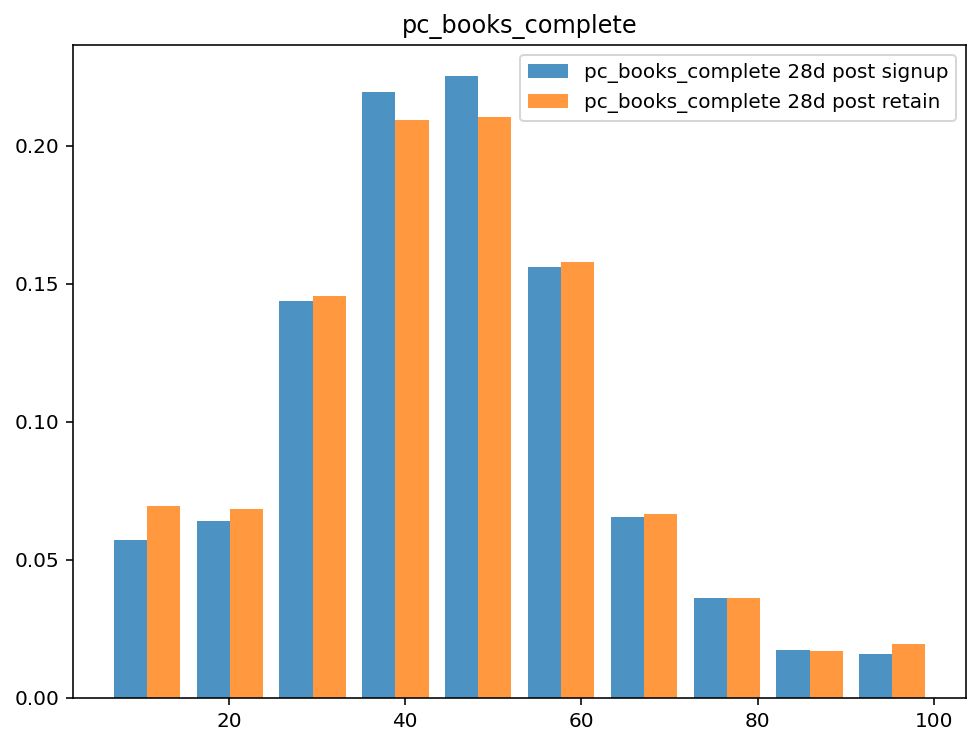

Average pc_books_complete 28d post signup 45, 28d post retain 44



In [50]:
for _ in comparison_stats:
    
    if _ in ["surfaces", "days_active", "pc_books_complete"]:
        x = df_f28d_stats[_]
        y = df_r28d_stats[_]
    else:
        # winsorize as data as extreme long tail
        x = winsorize(df_f28d_stats[_], limits=[0.0, 0.1])
        y = winsorize(df_r28d_stats[_], limits=[0.0, 0.1])
    
    # normalise
    x_w = np.empty(x.shape)
    x_w.fill(1/x.shape[0])
    y_w = np.empty(y.shape)
    y_w.fill(1/y.shape[0])

    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.tight_layout()

    plt.hist([x, y], weights=[x_w, y_w], alpha=0.8, label=[f"{_} 28d post signup", f"{_} 28d post retain"])
    plt.legend(loc='upper right')
    plt.title(f'{_}')    

    plt.show()

    print(f"Average {_} 28d post signup {round(np.mean(x))}, 28d post retain {round(np.mean(y))}\n")

In [51]:
# what behaviour during the trial period seperates those who are active 5 days or more in their first 28 days?

In [52]:
df_f28d_stats["was_active_5d"] = [1 if i >= 5 else 0 for i in df_f28d_stats.days_active]

In [53]:
f28d_comparisons = ["avg_min_per_book", "pc_books_complete", "avg_min_per_day", "surfaces", "books_per_category"]

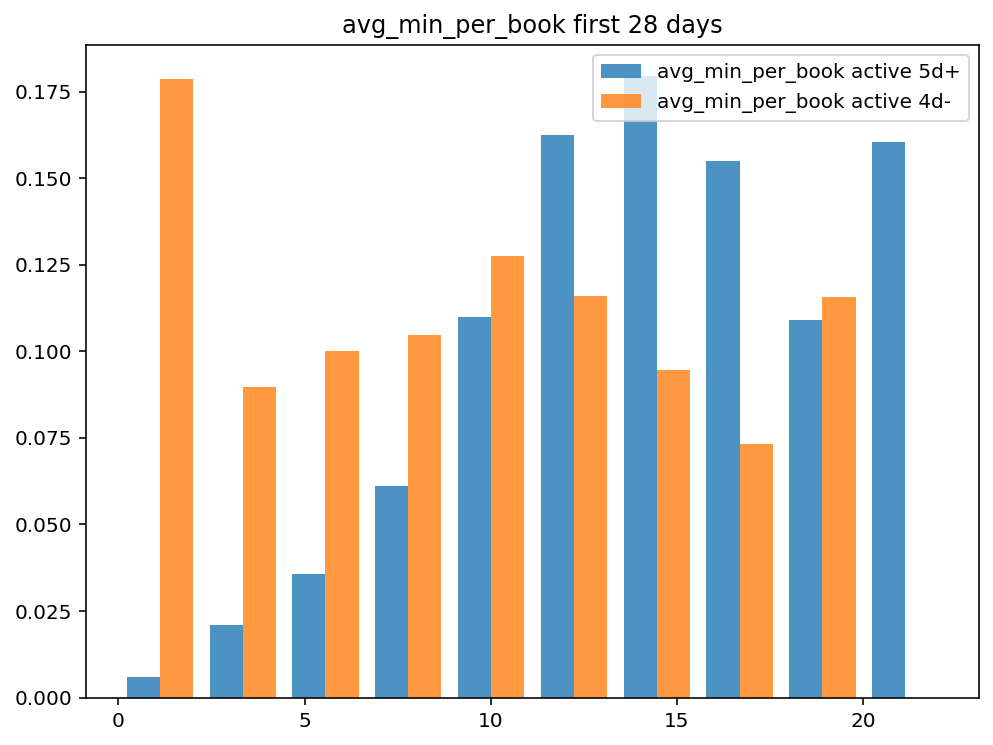

Average avg_min_per_book in first 28 days, for active 5d+ 15, active 4d- 9



<ipython-input-54-aecd02d0cd10>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = df_r28d_stats[df_f28d_stats.was_active_5d == 0][_]


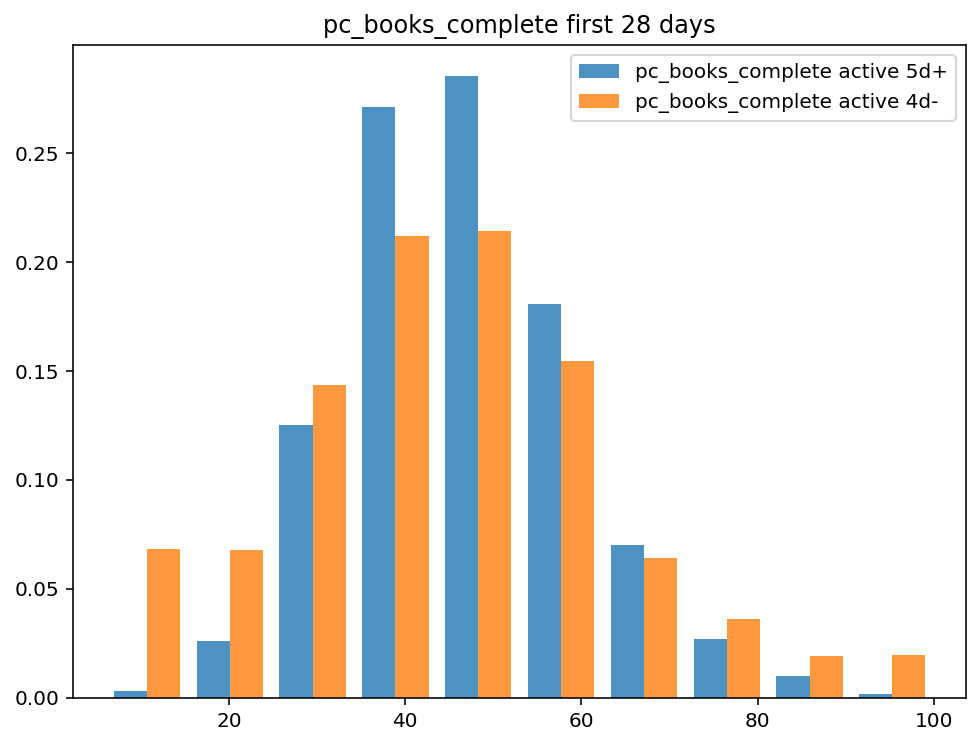

Average pc_books_complete in first 28 days, for active 5d+ 47, active 4d- 44



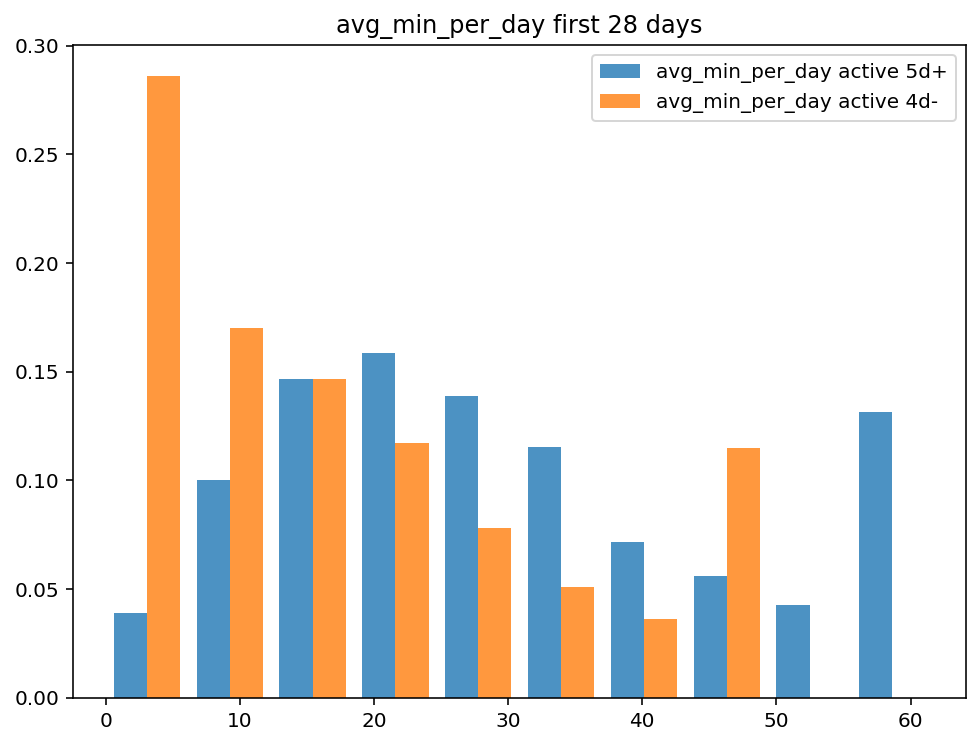

Average avg_min_per_day in first 28 days, for active 5d+ 30, active 4d- 18



<ipython-input-54-aecd02d0cd10>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = df_r28d_stats[df_f28d_stats.was_active_5d == 0][_]


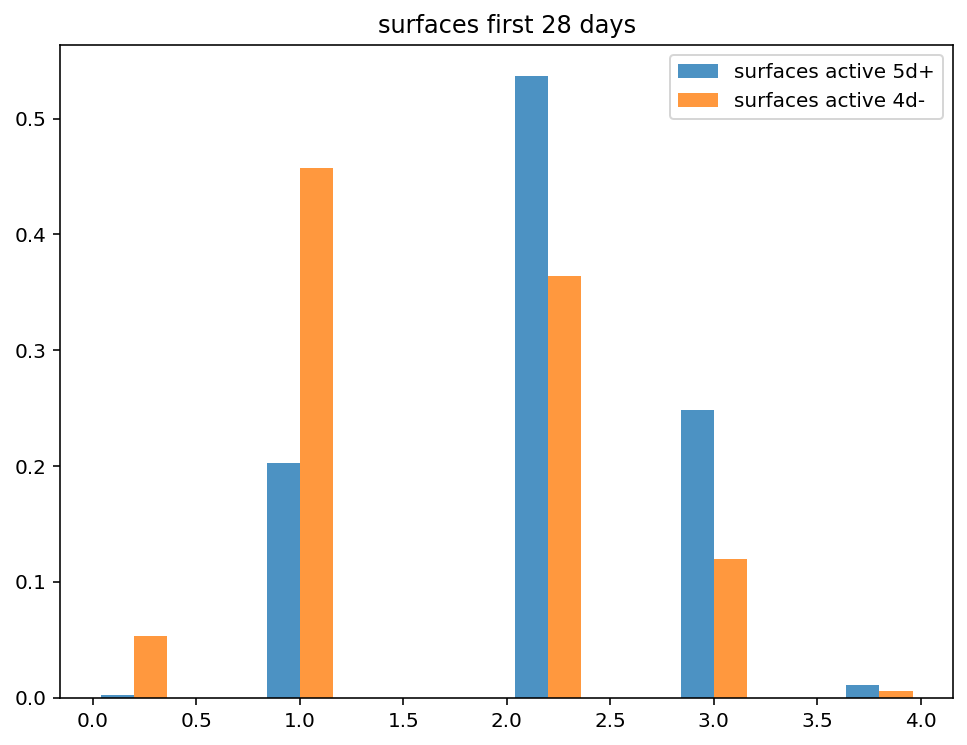

Average surfaces in first 28 days, for active 5d+ 2, active 4d- 2



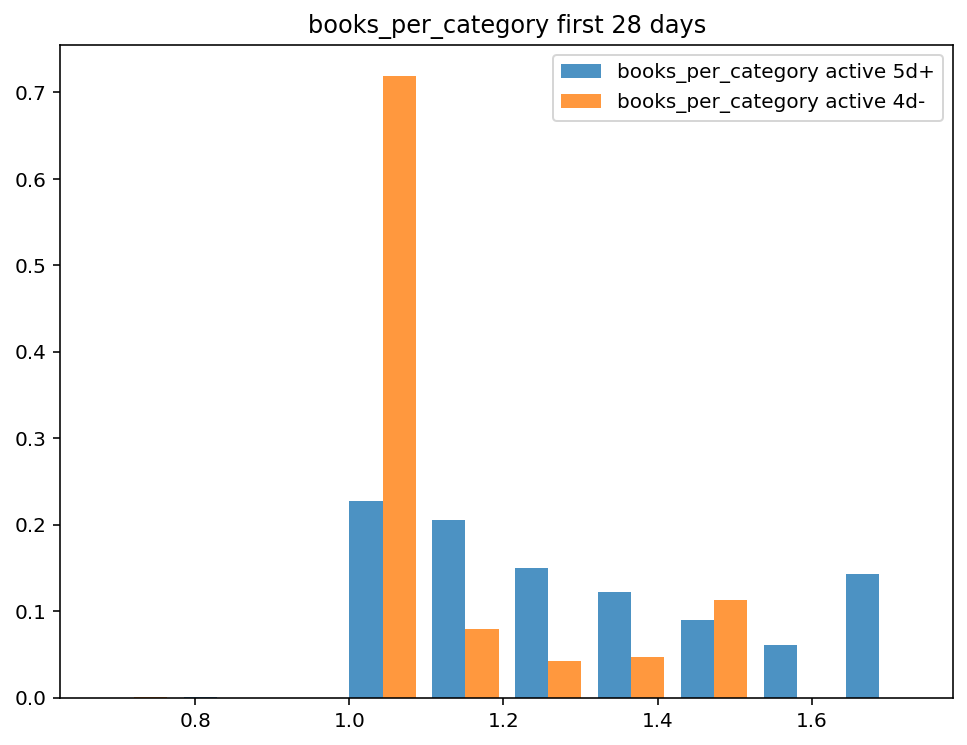

Average books_per_category in first 28 days, for active 5d+ 1, active 4d- 1



In [54]:
for _ in f28d_comparisons:
    
    if _ in ["surfaces", "days_active", "pc_books_complete"]:
        x = df_f28d_stats[df_f28d_stats.was_active_5d == 1][_]
        y = df_r28d_stats[df_f28d_stats.was_active_5d == 0][_]
    else:
        # winsorize as data as extreme long tail
        x = winsorize(df_f28d_stats[df_f28d_stats.was_active_5d == 1][_], limits=[0.0, 0.1])
        y = winsorize(df_f28d_stats[df_f28d_stats.was_active_5d == 0][_], limits=[0.0, 0.1])
    
    # normalise
    x_w = np.empty(x.shape)
    x_w.fill(1/x.shape[0])
    y_w = np.empty(y.shape)
    y_w.fill(1/y.shape[0])

    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.tight_layout()

    plt.hist([x, y], weights=[x_w, y_w], alpha=0.8, label=[f"{_} active 5d+", f"{_} active 4d-"])
    plt.legend(loc='upper right')
    plt.title(f'{_} first 28 days')    

    plt.show()

    print(f"Average {_} in first 28 days, for active 5d+ {round(np.mean(x))}, active 4d- {round(np.mean(y))}\n")

In [55]:
# digging into content

In [56]:
df_f28d_state = df_f28d_stats[["user_id", "was_active_5d"]].copy()

In [57]:
df_base = pd.merge(df_base, df_f28d_state, how="left", on="user_id")

In [58]:
df_books = df_base.groupby(["title", "categories", "was_active_5d"]).agg(
        people_opened=("user_id", "nunique"),
        time_spent_in_book_m=("time_spent_in_book_m", sum),    
        chapters_opened=("chapters_opened", sum),
        chapters_total=("chapters_total", sum),
    ).reset_index()

df_books["mins_per_person"] = df_books.time_spent_in_book_m / df_books.people_opened
df_books["avg_pc_book_complete"] = round(df_books.chapters_opened / df_books.chapters_total,2)*100

In [59]:
# pc of active group opened
_ = df_f28d_stats.groupby("was_active_5d").size().reset_index(name='users')

users_active_5d_plus = _[_.was_active_5d==1].users.values[0]
users_active_4d_minus = _[_.was_active_5d==0].users.values[0]

def pc_of_group(x, y):
    
    if x == 1:
        i = round(y / users_active_5d_plus, 3)*100
    elif x == 0:
        i = round(y / users_active_4d_minus, 3)*100
        
    return i

In [60]:
df_books["pc_of_group_opened"] = [pc_of_group(x, y) for x, y in zip(df_books.was_active_5d, df_books.people_opened)]

In [61]:
content_compare = ["people_opened", "time_spent_in_book_m", "mins_per_person", "avg_pc_book_complete"]

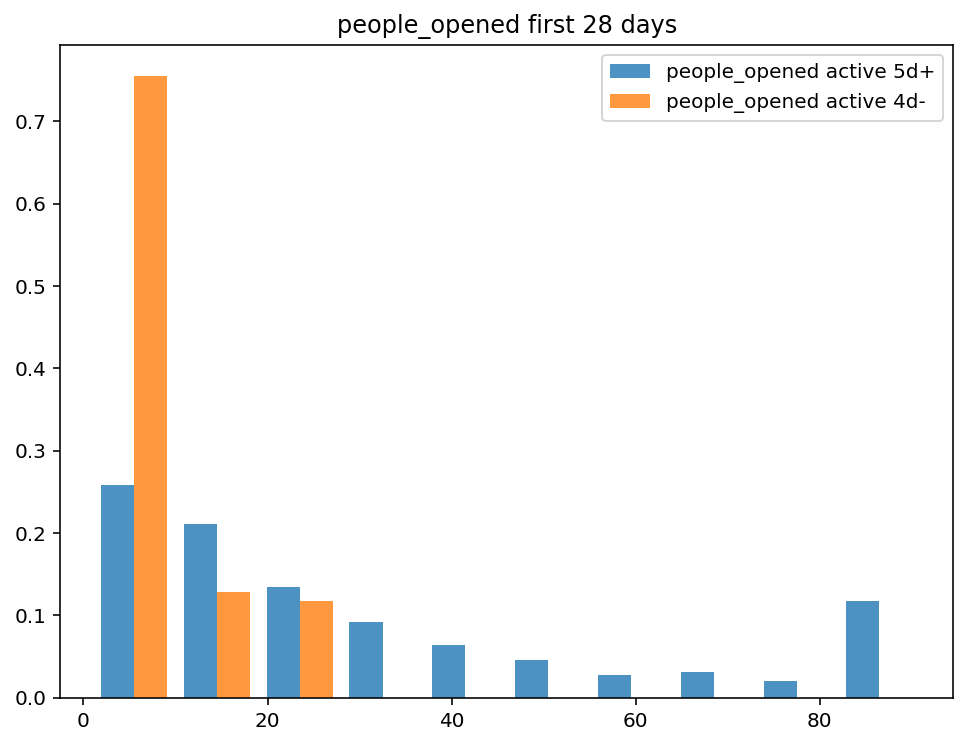

Average people_opened in first 28 days, for active 5d+ 31, active 4d- 7



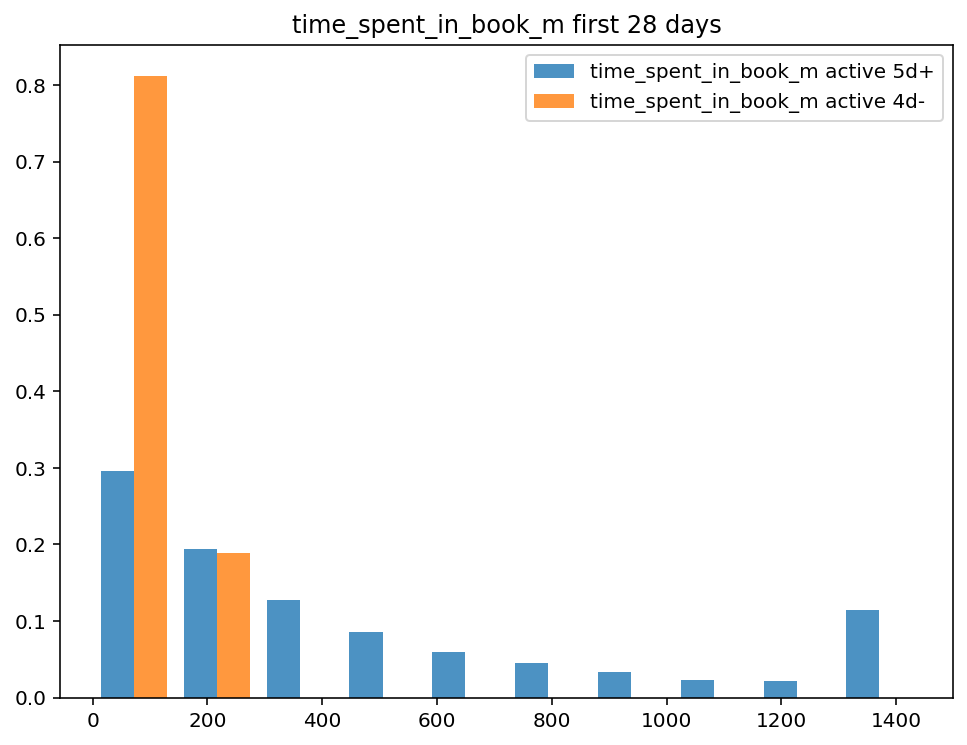

Average time_spent_in_book_m in first 28 days, for active 5d+ 470, active 4d- 75



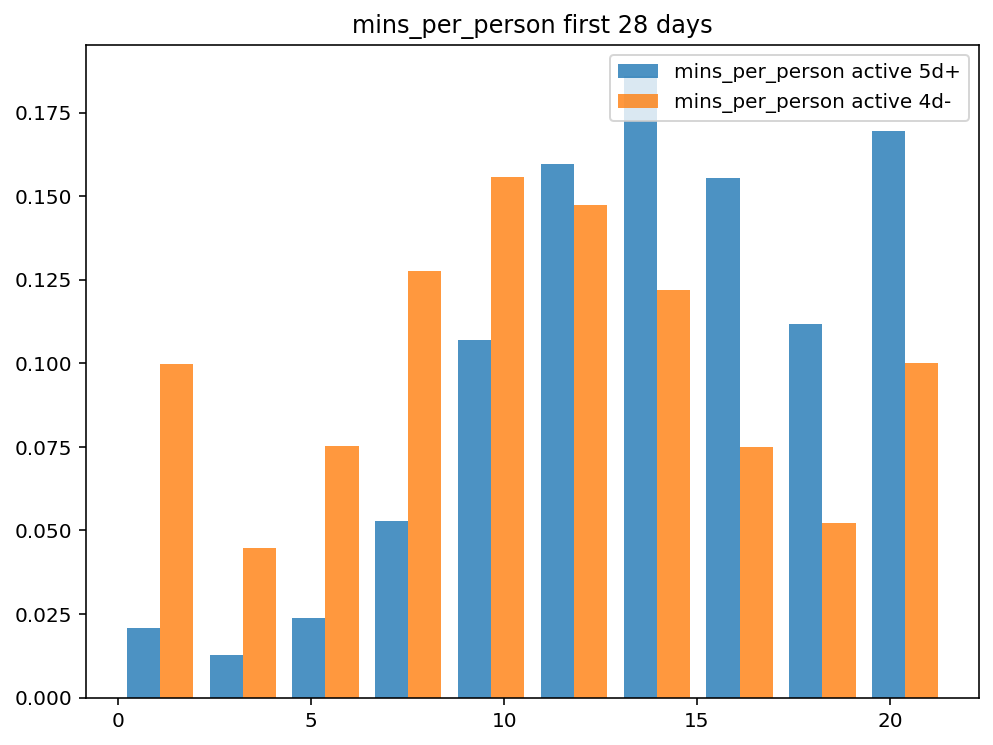

Average mins_per_person in first 28 days, for active 5d+ 14, active 4d- 11



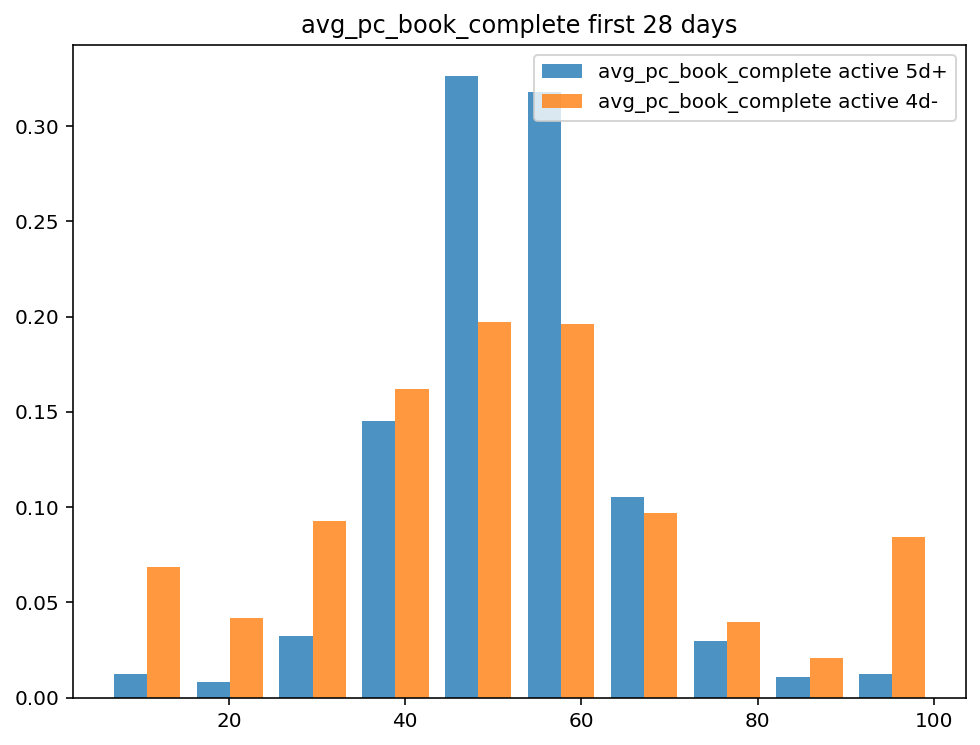

Average avg_pc_book_complete in first 28 days, for active 5d+ 52, active 4d- 51



In [62]:
for _ in content_compare:
    
    x = df_books[df_books.was_active_5d == 1][_]
    y = df_books[df_books.was_active_5d == 0][_]
    
    if _ in ["avg_pc_book_complete", "pc_of_group_opened"]:
        x = df_books[df_books.was_active_5d == 1][_]
        y = df_books[df_books.was_active_5d == 0][_]
    else:
        # winsorize as data as extreme long tail
        x = winsorize(df_books[df_books.was_active_5d == 1][_], limits=[0.0, 0.1])
        y = winsorize(df_books[df_books.was_active_5d == 0][_], limits=[0.0, 0.1])
    
    # normalise
    x_w = np.empty(x.shape)
    x_w.fill(1/x.shape[0])
    y_w = np.empty(y.shape)
    y_w.fill(1/y.shape[0])

    fig = plt.figure()
    fig.set_size_inches(8, 6)
    plt.tight_layout()

    plt.hist([x, y], weights=[x_w, y_w], alpha=0.8, label=[f"{_} active 5d+", f"{_} active 4d-"])
    plt.legend(loc='upper right')
    plt.title(f'{_} first 28 days')    

    plt.show()

    print(f"Average {_} in first 28 days, for active 5d+ {round(np.mean(x))}, active 4d- {round(np.mean(y))}\n")

In [63]:
alt.Chart(df_books[df_books.pc_of_group_opened >= 7]).mark_bar().encode(
    x="pc_of_group_opened",
    y=alt.Y('title:N', sort='-x'),
    color="was_active_5d:N"
).properties(height=200)

alt.Chart(...)

In [64]:
# for i in df_books.title.unique():
#     print(i)

In [65]:
alt.Chart(df_books[(df_books.was_active_5d == 0) & (df_books.pc_of_group_opened >= 2)]).mark_bar().encode(
    x="pc_of_group_opened",
    y=alt.Y('title:N', sort='-x'),
    color="was_active_5d:N"
).properties(height=200)

alt.Chart(...)

In [66]:
df_books[df_books.title == "The 7 Habits of Highly Effective People"][["was_active_5d","mins_per_person", "avg_pc_book_complete", "pc_of_group_opened"]]

was_active_5d  mins_per_person  avg_pc_book_complete  pc_of_group_opened
5116            0.0        17.680297                  38.0                 4.3
5117            1.0        27.030833                  36.0                12.5

In [67]:
df_books[df_books.title == "Living Forward"][["was_active_5d","mins_per_person", "avg_pc_book_complete", "pc_of_group_opened"]]

was_active_5d  mins_per_person  avg_pc_book_complete  pc_of_group_opened
3444            0.0        11.068794                  43.0                 3.0
3445            1.0        18.618222                  43.0                10.1

In [68]:
df_books[df_books.title == "13 Things Mentally Strong People Don't Do"][["was_active_5d","mins_per_person", "avg_pc_book_complete", "pc_of_group_opened"]]

was_active_5d  mins_per_person  avg_pc_book_complete  pc_of_group_opened
29            0.0        17.563538                  36.0                 4.1
30            1.0        27.587950                  34.0                 9.4

In [69]:
cat_rank = df_base.groupby(["categories", "was_active_5d"]).agg(
        people_opened=("user_id", "nunique"),
        time_spent_in_book_m=("time_spent_in_book_m", sum),    
        chapters_opened=("chapters_opened", sum),
        chapters_total=("chapters_total", sum),
    ).reset_index()

cat_rank["mins_per_person"] = cat_rank.time_spent_in_book_m / cat_rank.people_opened
cat_rank["avg_pc_book_complete"] = round(cat_rank.chapters_opened / cat_rank.chapters_total,2)*100

cat_rank["pc_of_group_opened"] = [pc_of_group(x, y) for x, y in zip(cat_rank.was_active_5d, cat_rank.people_opened)]

In [70]:
top_cats = cat_rank.groupby("categories")["pc_of_group_opened"].sum().reset_index()
cats_filter = top_cats[top_cats.pc_of_group_opened >= 20].categories.values

In [71]:
chart = alt.Chart(cat_rank[cat_rank.categories.isin(cats_filter)]).mark_bar().encode(
    x=alt.X("categories:N", sort='-y'),
    y=alt.Y('pc_of_group_opened:Q'),
    color="was_active_5d:N"
).properties(width=800)

chart

alt.Chart(...)

In [72]:
# is there a top book per category?

In [73]:
df_books["popularity_rank"] = df_books.pc_of_group_opened * df_books.mins_per_person

In [74]:
print(f"""
Top 10 for those active 5 days or more in their first 28 days:
{df_books[(df_books.was_active_5d == 1)][["title", "was_active_5d", "pc_of_group_opened", "mins_per_person", "popularity_rank"]].sort_values("popularity_rank", ascending=False).head(10).to_string(index=False)}\n

Top 10 for those active 4 days or less in their first 28 days:
{df_books[(df_books.was_active_5d == 0)][["title", "was_active_5d", "pc_of_group_opened", "mins_per_person", "popularity_rank"]].sort_values("popularity_rank", ascending=False).head(10).to_string(index=False)}\n
""")


Top 10 for those active 5 days or more in their first 28 days:
                                     title  was_active_5d  pc_of_group_opened  mins_per_person  popularity_rank
   The 7 Habits of Highly Effective People            1.0                12.5        27.030833       337.885417
 13 Things Mentally Strong People Don't Do            1.0                 9.4        27.587950       259.326727
                            Die 1%-Methode            1.0                 9.7        20.076469       194.741748
                                  Becoming            1.0                 6.5        29.018437       188.619840
                            Living Forward            1.0                10.1        18.618222       188.044044
                       The Disordered Mind            1.0                 8.5        19.055677       161.973257
                         12 Rules For Life            1.0                 5.9        27.218487       160.589071
               Words Can Change Your Bra

In [75]:
df_top_books = df_base.groupby(["title", "categories"]).agg(
        people_opened=("user_id", "nunique"),
        time_spent_in_book_m=("time_spent_in_book_m", sum),    
        chapters_opened=("chapters_opened", sum),
        chapters_total=("chapters_total", sum),
    ).reset_index()

df_top_books["mins_per_person"] = df_top_books.time_spent_in_book_m / df_top_books.people_opened
df_top_books["avg_pc_book_complete"] = round(df_books.chapters_opened / df_top_books.chapters_total,2)*100

totalusers = df_base.user_id.nunique()
df_top_books["pc_of_group_opened"] = [i / totalusers for i in df_top_books.people_opened]

df_top_books["popularity_rank"] = df_top_books.pc_of_group_opened * df_top_books.mins_per_person

In [76]:
for _ in cats_filter:
    print(f"""
    Top books in {_}
    
    {df_top_books[(df_top_books.categories == _)][["title", "pc_of_group_opened", "mins_per_person", "popularity_rank"]].sort_values("popularity_rank", ascending=False).head(1).to_string(index=False)}
    """)


    Top books in Biography & Memoir
    
        title  pc_of_group_opened  mins_per_person  popularity_rank
 Becoming            0.043199        26.569575         1.147782
    

    Top books in Career & Success
    
                      title  pc_of_group_opened  mins_per_person  popularity_rank
 The Success Principles            0.039221        13.761536         0.539743
    

    Top books in Communication Skills
    
                     title  pc_of_group_opened  mins_per_person  popularity_rank
 How to Talk to Anyone            0.023728        16.651569          0.39511
    

    Top books in Communication Skills, Career & Success
    
                                     title  pc_of_group_opened  mins_per_person  popularity_rank
 How to Win Friends & Influence People            0.032801        24.916844         0.817288
    

    Top books in Economics
    
                title  pc_of_group_opened  mins_per_person  popularity_rank
 The Deficit Myth            0.010608      

In [77]:
# top_surface & top_category
df_f28d_stats.drop(columns=["chapters_total"], inplace=True)

In [78]:
def surface_df(df_subs: pd.DataFrame, df_daily: pd.DataFrame, filter_col, start=0, stop=28) -> pd.DataFrame:
    df = pd.merge(df_subs, df_daily, on="user_id", how="left")

    df["days_since_signup"] = (df.opened_at_ds - df.signup_at_ts)
    df["days_since_signup"] = [i.days for i in df.days_since_signup]

    df["days_since_trial_retention"] = (df.opened_at_ds - df.trial_retention_at_ts)
    df["days_since_trial_retention"] = [i.days for i in df.days_since_trial_retention]

    # keep the 88% of cases that make sense
    df = df[df.days_trial_to_retention.isin([6, 7])]

    df = df[(df[filter_col] >= start) & (df[filter_col] <= stop)]

    surface = df.groupby(['user_id']).apply(lambda x: x.groupby('opened_from')['user_id'].count().to_dict()).to_list()
    s1 = [list(dict(sorted(i.items(), key=lambda item: item[1], reverse=True)).keys()) for i in surface]
    top_surface = [i[0] if len(i) > 1 else '' for i in s1]

    return top_surface

In [79]:
top_surface = surface_df(df_subs, df_base, "days_since_signup")

In [80]:
len(top_surface) == df_f28d_stats.shape[0]

True

In [81]:
df_f28d_stats["top_surface"] = top_surface

In [82]:
def t_category(df_subs: pd.DataFrame, df_daily: pd.DataFrame, filter_col, start=0, stop=28) -> pd.DataFrame:
    df = pd.merge(df_subs, df_daily, on="user_id", how="left")

    df["days_since_signup"] = (df.opened_at_ds - df.signup_at_ts)
    df["days_since_signup"] = [i.days for i in df.days_since_signup]

    df["days_since_trial_retention"] = (df.opened_at_ds - df.trial_retention_at_ts)
    df["days_since_trial_retention"] = [i.days for i in df.days_since_trial_retention]

    # keep the 88% of cases that make sense
    df = df[df.days_trial_to_retention.isin([6, 7])]

    df = df[(df[filter_col] >= start) & (df[filter_col] <= stop)]

    cats = df.groupby(['user_id']).apply(lambda x: x.groupby('categories')['user_id'].count().to_dict()).to_list()
    c1 = [list(dict(sorted(i.items(), key=lambda item: item[1], reverse=True)).keys()) for i in cats]
    top_cat = [i[0].split(", ")[0] if len(i) > 1 else '' for i in c1]

    return top_cat

In [83]:
df_f28d_stats["top_category"] = t_category(df_subs, df_base, "days_since_signup")

In [84]:
df_tc_active = df_f28d_stats[df_f28d_stats.was_active_5d == 1]["top_category"].value_counts(normalize=True).rename_axis('top_category').reset_index(name='pc')
df_tc_nonactive = df_f28d_stats[df_f28d_stats.was_active_5d == 0]["top_category"].value_counts(normalize=True).rename_axis('top_category').reset_index(name='pc')

df_tc = pd.merge(df_tc_active, df_tc_nonactive, how="left", on="top_category", suffixes=("_active_5d_plus", "_active_4d_minus"))

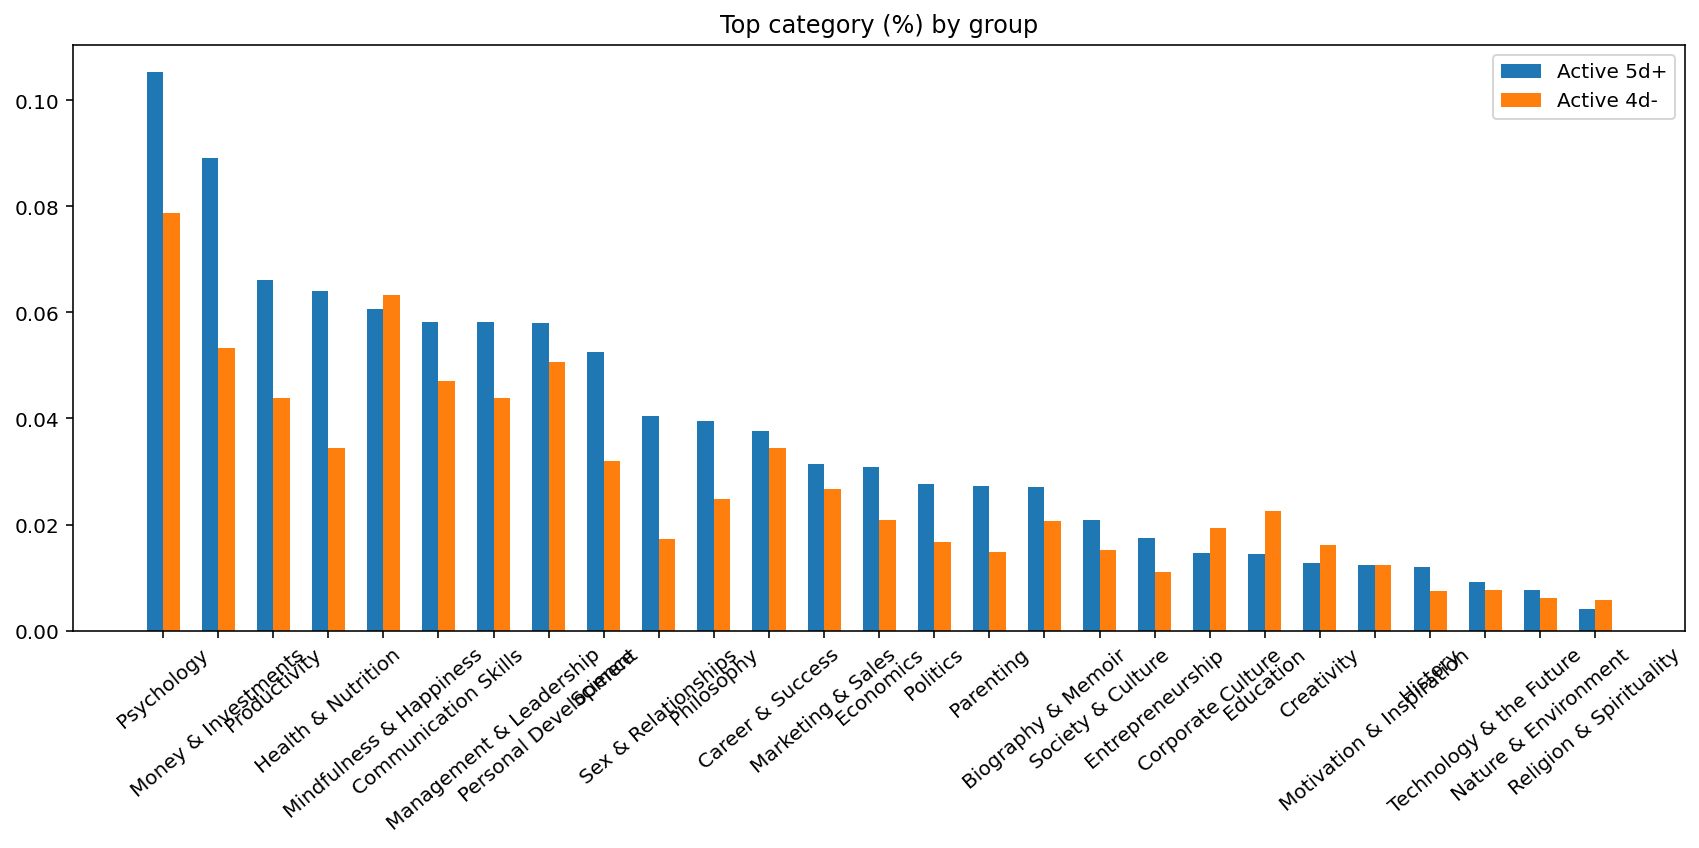

In [85]:
data = df_tc[df_tc.top_category != '']
labels = data.top_category.values
x = np.arange(len(labels))
y1 = data.pc_active_5d_plus.values
y2 = data.pc_active_4d_minus.values

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

width = 0.3
rects1 = ax.bar(x - width/2, y1, width, label='Active 5d+')
rects2 = ax.bar(x + width/2, y2, width, label='Active 4d-')

ax.set_title('Top category (%) by group')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=40)
ax.legend()  

fig.tight_layout()
plt.savefig("md_refs/top_cat.png", dpi=300, format="png")
plt.show()

In [86]:
df_ts_active = df_f28d_stats[df_f28d_stats.was_active_5d == 1]["top_surface"].value_counts(normalize=True).rename_axis('top_surface').reset_index(name='pc')
df_ts_nonactive = df_f28d_stats[df_f28d_stats.was_active_5d == 0]["top_surface"].value_counts(normalize=True).rename_axis('top_surface').reset_index(name='pc')

df_ts = pd.merge(df_ts_active, df_ts_nonactive, how="left", on="top_surface", suffixes=("_active_5d_plus", "_active_4d_minus"))

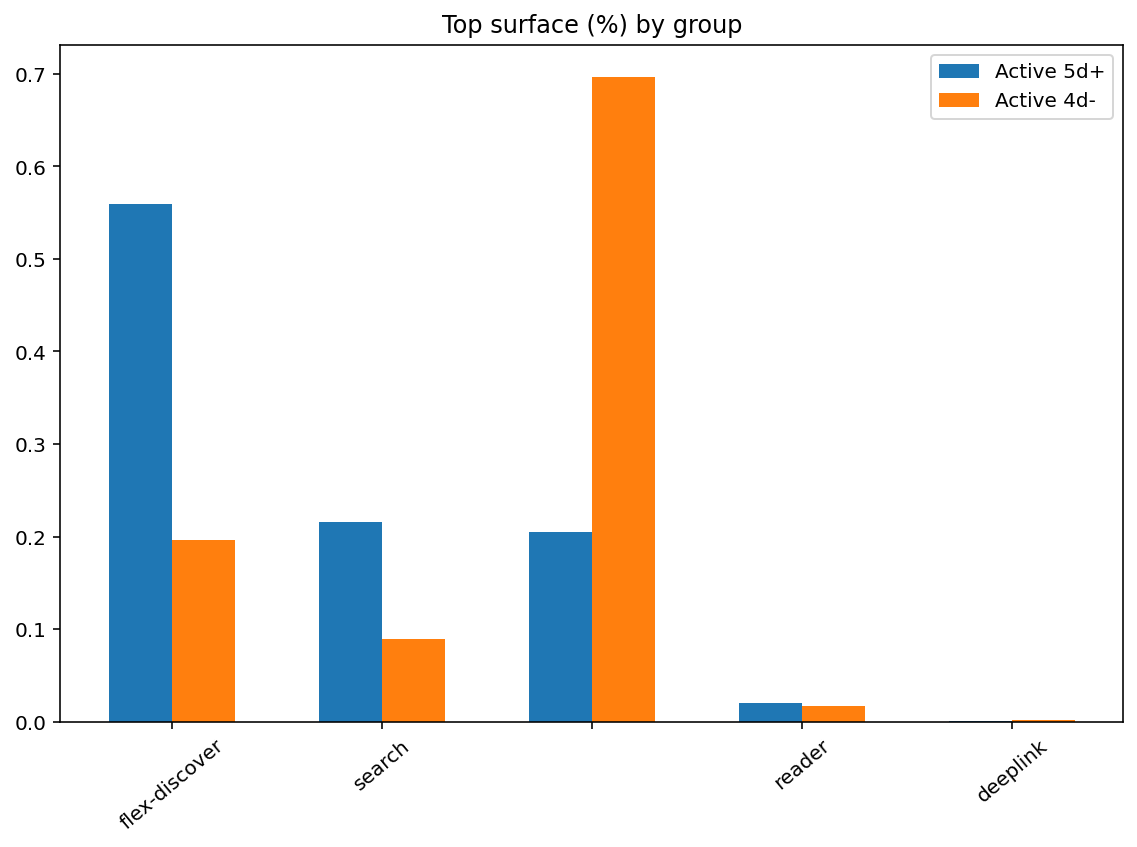

In [87]:
data = df_ts
labels = data.top_surface.values
x = np.arange(len(labels))
y1 = data.pc_active_5d_plus.values
y2 = data.pc_active_4d_minus.values

fig, ax = plt.subplots()
fig.set_size_inches(8, 6)

width = 0.3
rects1 = ax.bar(x - width/2, y1, width, label='Active 5d+')
rects2 = ax.bar(x + width/2, y2, width, label='Active 4d-')

ax.set_title('Top surface (%) by group')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=40)
ax.legend()  

fig.tight_layout()
plt.savefig("md_refs/top_surface.png", dpi=300, format="png")
plt.show()

In [88]:
features = df_f28d_stats.columns[1:]

In [89]:
df_f28d_fts = df_f28d_stats[features]
df_f28d_fts.drop(columns=["time_spent_in_book_s"], inplace=True)

/Users/widgyrogers/Library/Caches/pypoetry/virtualenvs/product-analytics-1D3fELKC-py3.8/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [90]:
enc = OneHotEncoder(sparse=False)
t = enc.fit_transform(df_f28d_fts.select_dtypes(include=[object]))

In [91]:
enc.get_feature_names()

array(['x0_', 'x0_deeplink', 'x0_flex-discover', 'x0_reader', 'x0_search',
       'x1_', 'x1_Biography & Memoir', 'x1_Career & Success',
       'x1_Communication Skills', 'x1_Corporate Culture', 'x1_Creativity',
       'x1_Economics', 'x1_Education', 'x1_Entrepreneurship',
       'x1_Health & Nutrition', 'x1_History',
       'x1_Management & Leadership', 'x1_Marketing & Sales',
       'x1_Mindfulness & Happiness', 'x1_Money & Investments',
       'x1_Motivation & Inspiration', 'x1_Nature & Environment',
       'x1_Parenting', 'x1_Personal Development', 'x1_Philosophy',
       'x1_Politics', 'x1_Productivity', 'x1_Psychology',
       'x1_Religion & Spirituality', 'x1_Science',
       'x1_Sex & Relationships', 'x1_Society & Culture',
       'x1_Technology & the Future'], dtype=object)

In [92]:
encoded_df = pd.DataFrame(t, columns=enc.get_feature_names())

In [93]:
model_data = pd.concat([df_f28d_fts, encoded_df], axis=1)

In [94]:
y = model_data.was_active_5d
# remove non-numerical data and colliders (those that reflects days active)
model_data.drop(columns=["top_surface", "top_category", "was_active_5d", "time_spent_in_book_m", "chapters_opened", "books", "categories", "days_active", "surfaces"], inplace=True)

In [95]:
model_data.columns

Index(['avg_min_per_book', 'avg_min_per_day', 'chapters_per_book',
       'books_per_day', 'books_per_category', 'pc_books_complete', 'x0_',
       'x0_deeplink', 'x0_flex-discover', 'x0_reader', 'x0_search', 'x1_',
       'x1_Biography & Memoir', 'x1_Career & Success',
       'x1_Communication Skills', 'x1_Corporate Culture', 'x1_Creativity',
       'x1_Economics', 'x1_Education', 'x1_Entrepreneurship',
       'x1_Health & Nutrition', 'x1_History', 'x1_Management & Leadership',
       'x1_Marketing & Sales', 'x1_Mindfulness & Happiness',
       'x1_Money & Investments', 'x1_Motivation & Inspiration',
       'x1_Nature & Environment', 'x1_Parenting', 'x1_Personal Development',
       'x1_Philosophy', 'x1_Politics', 'x1_Productivity', 'x1_Psychology',
       'x1_Religion & Spirituality', 'x1_Science', 'x1_Sex & Relationships',
       'x1_Society & Culture', 'x1_Technology & the Future'],
      dtype='object')

<AxesSubplot:>

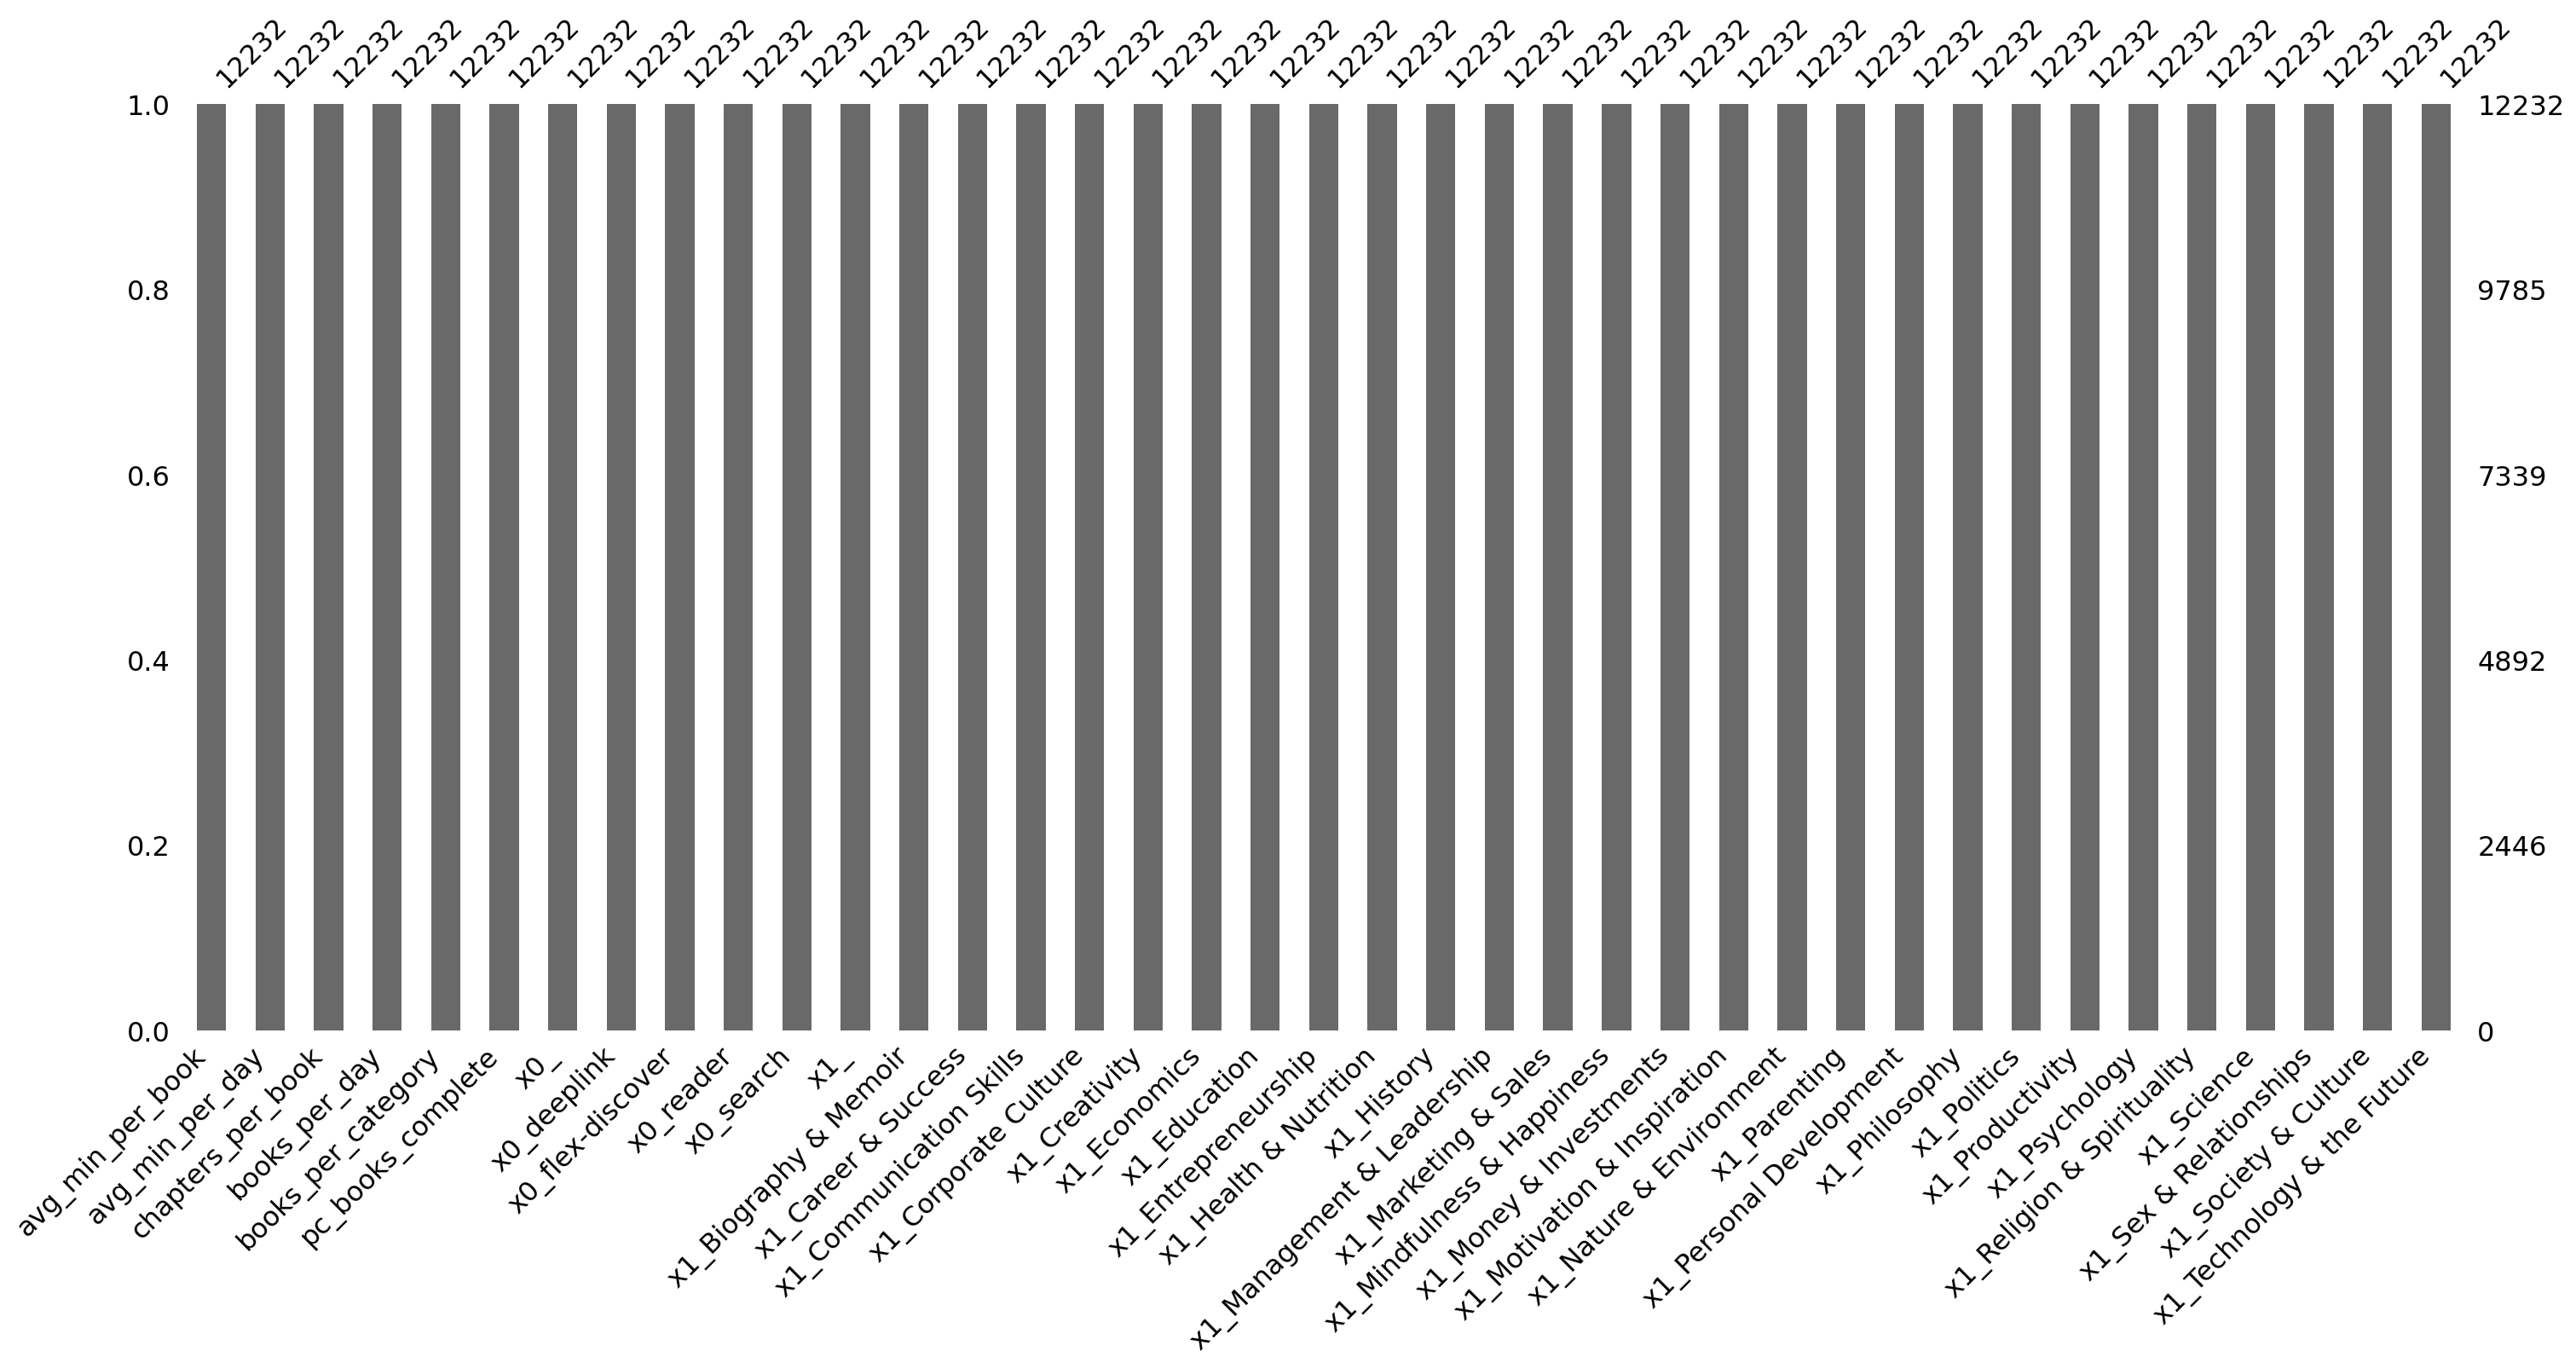

In [96]:
msno.bar(model_data)

In [97]:
model_data.avg_min_per_book = [round(i) for i in model_data.avg_min_per_book]

model_data.avg_min_per_book = [round(i) for i in model_data.avg_min_per_book]

model_data.books_per_day = [round(i) for i in model_data.books_per_day]

In [98]:
model_data.books_per_category = [round(i) if i != float("inf") else 0 for i in model_data.books_per_category]

In [99]:
X = model_data

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [101]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3).fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [102]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.770299727520436


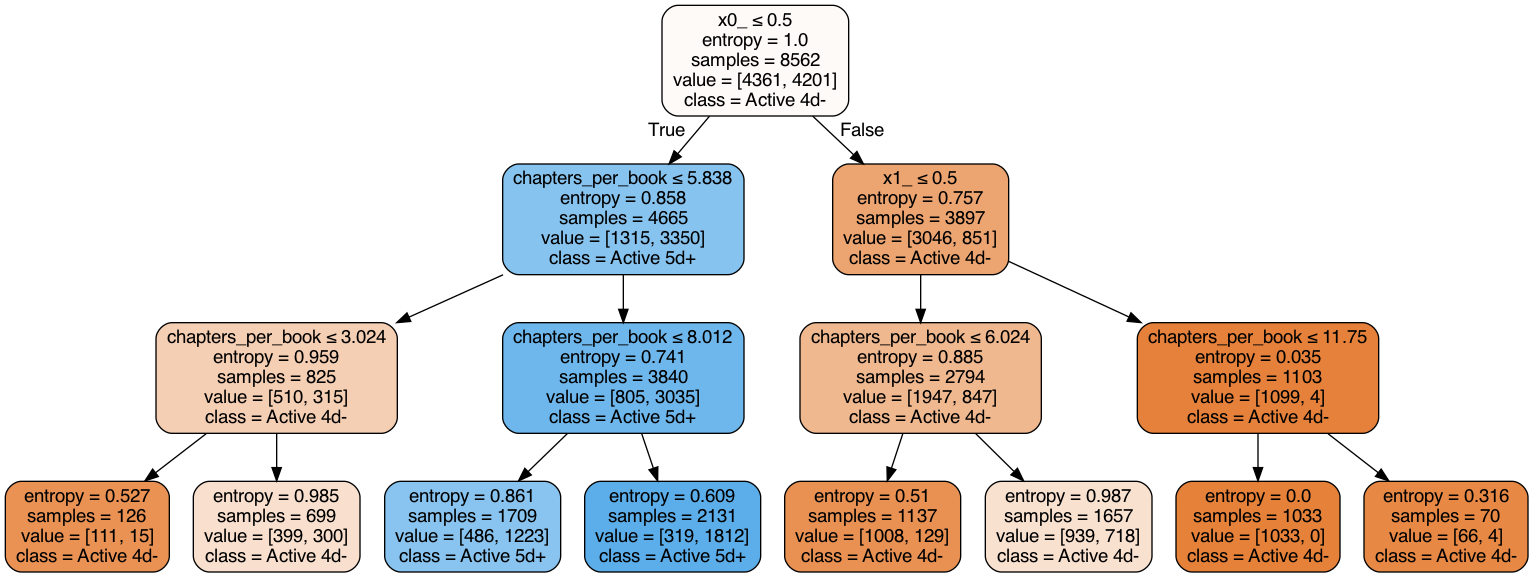

In [103]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X.columns,class_names=['Active 4d-','Active 5d+'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('md_refs/5d_active.png')
Image(graph.create_png())

In [104]:
# what behaviour during the trial period seperates those who are active 5 days or more in their first 28 days?

In [105]:
df_user_f28d = pd.merge(df_base, df_subs, on="user_id", how="left")

df_user_f28d["days_since_signup"] = (df_user_f28d.opened_at_ds - df_user_f28d.signup_at_ts)
df_user_f28d["days_since_signup"] = [i.days for i in df_user_f28d.days_since_signup]


df_user_f28d = df_user_f28d[df_user_f28d.days_since_signup <= 28]
df_user_f28d = df_user_f28d.groupby(["user_id"]).agg(
    time_spent_in_book_s=("time_spent_in_book_s", sum),
    time_spent_in_book_m=("time_spent_in_book_m", sum),
    chapters_opened=("chapters_opened", sum),
    categories=("categories", "nunique"),
    books=("title", "nunique"),
    surfaces=("opened_from", "nunique"),    
).reset_index()


df_user_f28d = pd.merge(df_user_f28d, df_f28d_active, on="user_id", how="left")

df_user_f28d["was_active_5d_in_first_28d"] = [1 if i >= 5 else 0 for i in df_user_f28d.days_active]

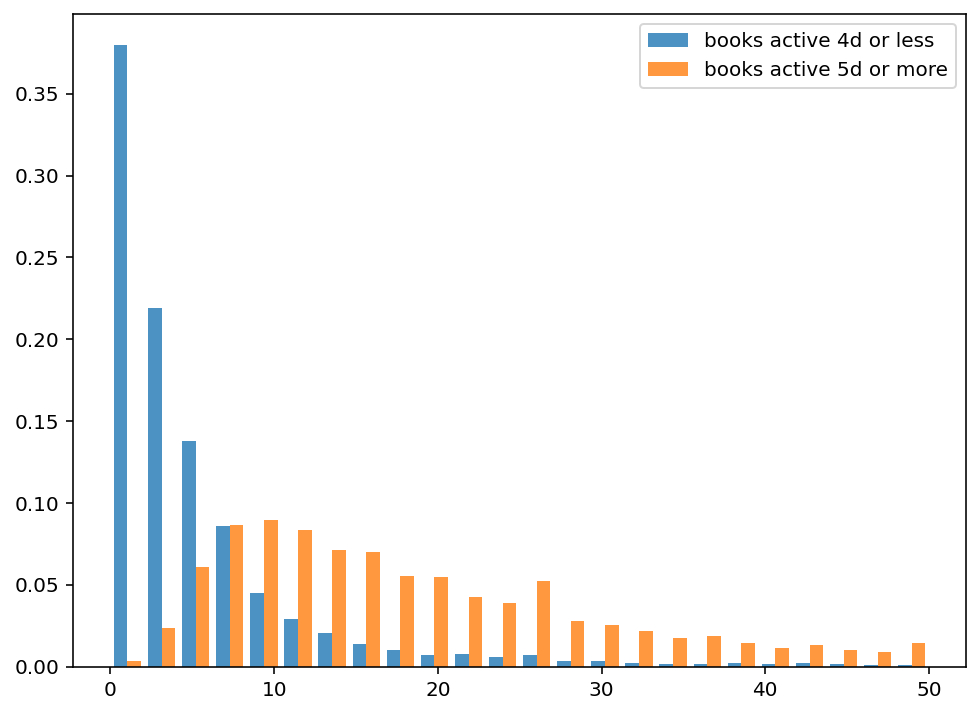

Average for active less than 5d 6, average for active 5 or more days 24


In [106]:
x = df_user_f28d[df_user_f28d.was_active_5d_in_first_28d == 0].books
y = df_user_f28d[df_user_f28d.was_active_5d_in_first_28d == 1].books
# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
fig.set_size_inches(8, 6)
plt.tight_layout()

bins = np.linspace(0, 50, 25)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['books active 4d or less', 'books active 5d or more'])
plt.legend(loc='upper right')

plt.show()

print(f"Average for active less than 5d {round(np.mean(x))}, average for active 5 or more days {round(np.mean(y))}")

In [107]:
# does behaviour look different pre and post retention?

In [108]:
df_pre = df_ud.copy()
df_pre = df_pre[df_pre.days_since_trial_retention < 0]

df_pre = df_pre.groupby(["user_id"]).agg(
    days_active=("opened_at", "nunique")   
).reset_index()

df_post = df_ud.copy()
df_post = df_post[df_post.days_since_trial_retention >= 0]

df_post = df_post.groupby(["user_id"]).agg(
    days_active=("opened_at", "nunique")   
).reset_index()


df_post_7d = df_ud.copy()
df_post_7d = df_post_7d[(df_post_7d.days_since_trial_retention >= 0) & (df_post_7d.days_since_trial_retention <=7)]

df_post_7d = df_post_7d.groupby(["user_id"]).agg(
    days_active=("opened_at", "nunique")   
).reset_index()

/Users/widgyrogers/Library/Caches/pypoetry/virtualenvs/product-analytics-1D3fELKC-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


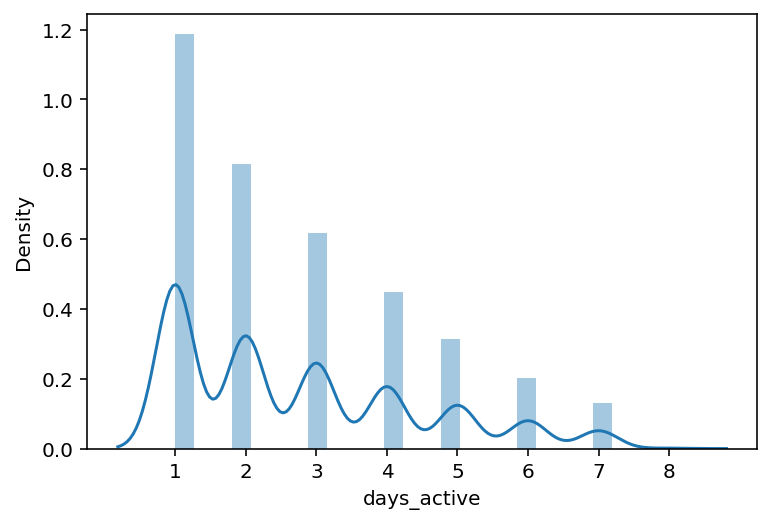

In [109]:
fig, ax = plt.subplots()
ax = sns.distplot(df_pre.days_active)
plt.xticks(df_pre.days_active.unique())
plt.show();

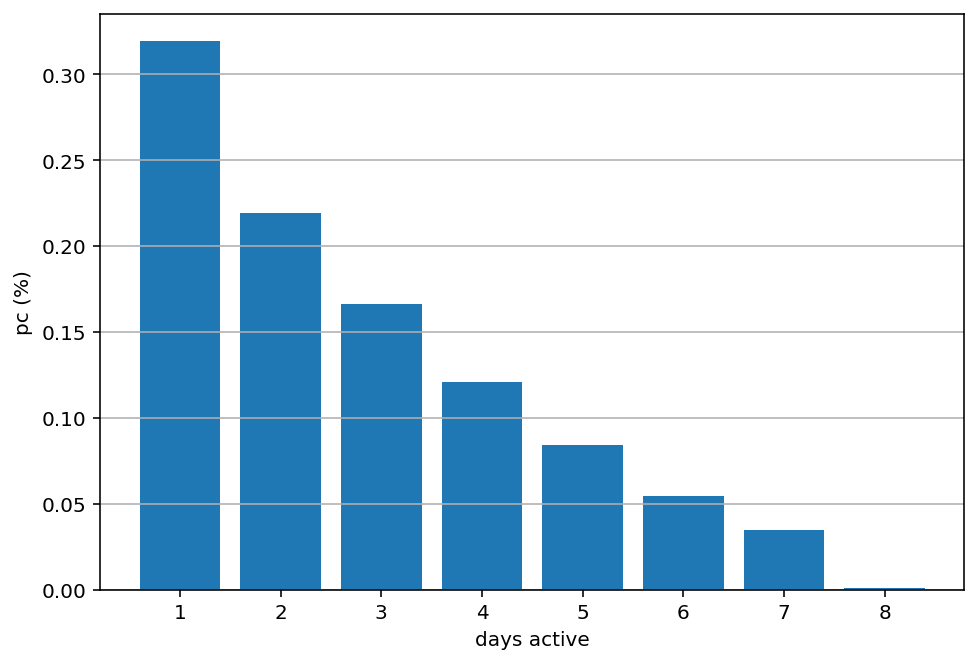

In [110]:
pre_active_pc = list(df_pre.days_active.value_counts(normalize=True))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()
ax.bar(sorted(df_pre.days_active.unique()),pre_active_pc)
ax.set_ylabel('pc (%)')
ax.set_xlabel('days active')
plt.show()

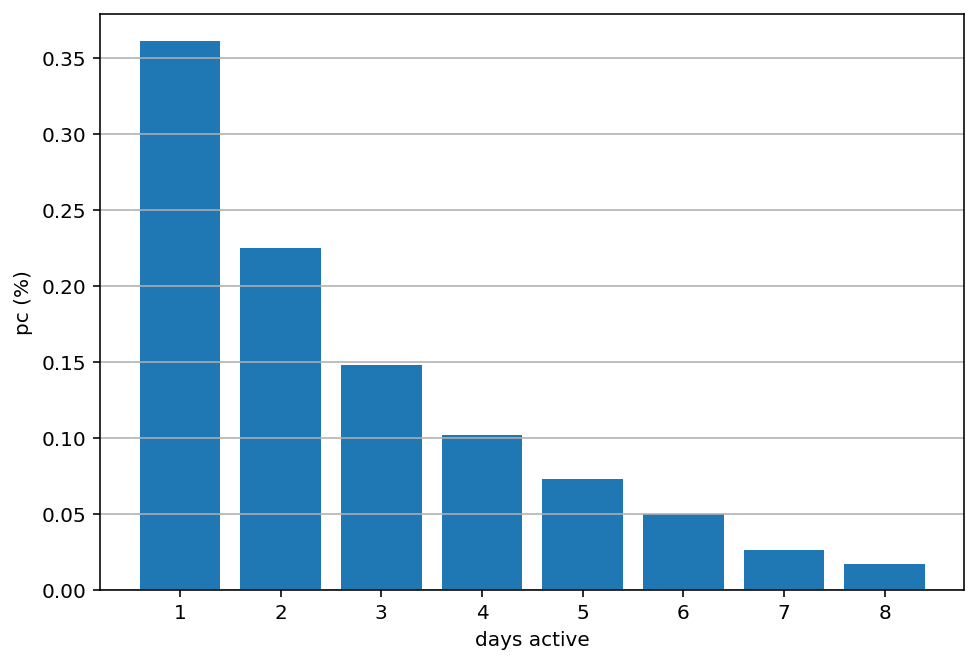

In [111]:
post7d_active_pc = list(df_post_7d.days_active.value_counts(normalize=True))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()
ax.bar(sorted(df_post_7d.days_active.unique()),post7d_active_pc)
ax.set_ylabel('pc (%)')
ax.set_xlabel('days active')
plt.show()

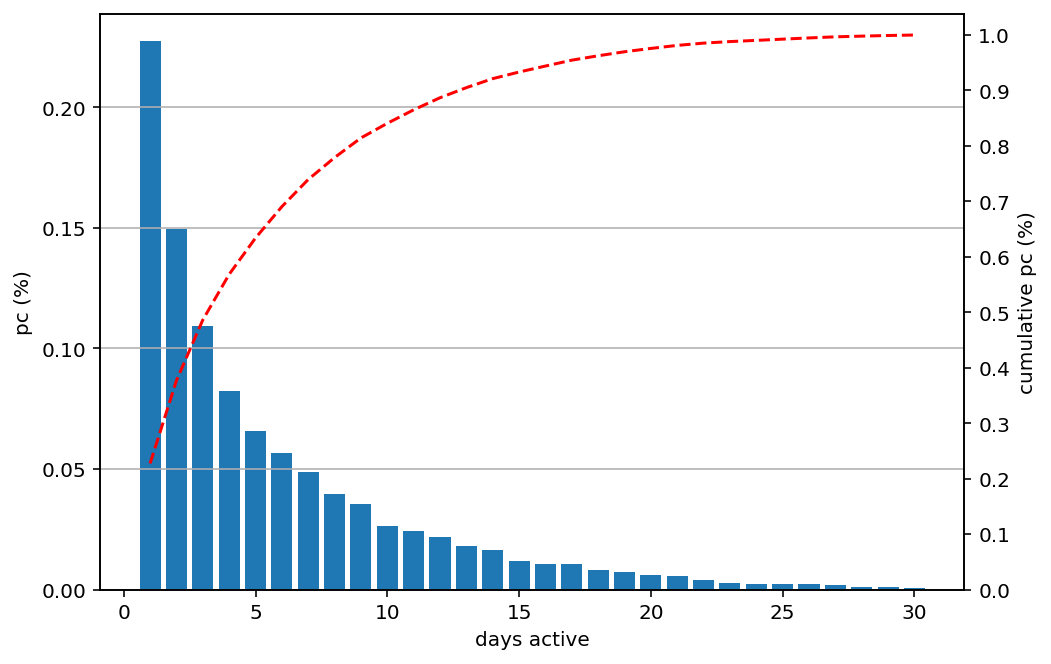

In [112]:
post_active_pc = list(df_post.days_active.value_counts(normalize=True))

post_active_pc_cumsum = [sum(post_active_pc[:i[0] + 1]) for i in enumerate(post_active_pc)]

x = sorted(df_post.days_active.unique())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()

ax.bar(x, post_active_pc)
ax.set_ylabel('pc (%)')
ax.set_xlabel('days active')

ax2=ax.twinx()
ax2.plot(x, post_active_pc_cumsum, 'r--')
ax2.set_yticks(np.arange(0.0, 1.1, 0.1))
ax2.set_ylabel('cumulative pc (%)')

plt.show()

In [113]:
# becomes more of a smiling curve after renewal, only slightly
# ie - more people are active 7/8 days, but the middle hollows out

kurtosis(df_pre.days_active), kurtosis(df_post.days_active), kurtosis(df_post_7d.days_active)

(-0.2702266185253168, 2.6867046741199054, 0.38550751973863306)

In [114]:
df_pre.shape[0], df_post_7d.shape[0]

(10200, 7904)

In [115]:
df_active_comp = pd.merge(df_pre, df_post_7d, on="user_id", suffixes=('_pre', '_post'), how="inner")

In [116]:
df_active_comp["diff_active"] = df_active_comp.days_active_post - df_active_comp.days_active_pre
df_active_comp["is_more_or_same_active"] = [1 if i >= 0 else 0 for i in df_active_comp.diff_active]

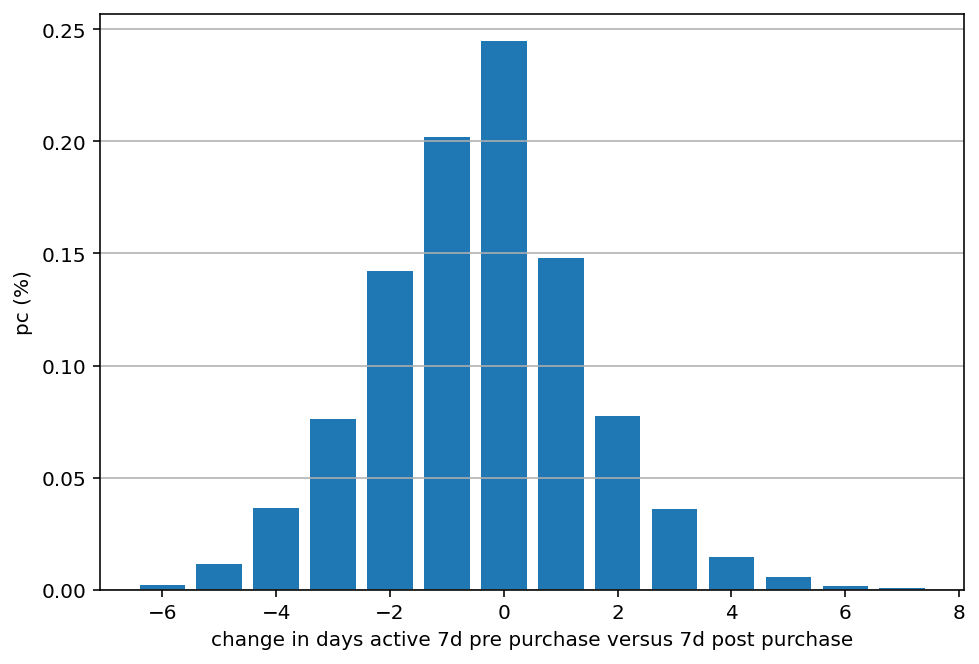

In [117]:
diff_pc = list(df_active_comp.diff_active.value_counts(normalize=True))
x = df_active_comp.diff_active.value_counts(normalize=True).index.tolist()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.yaxis.grid()
ax.bar(x,diff_pc)
ax.set_ylabel('pc (%)')
ax.set_xlabel('change in days active 7d pre purchase versus 7d post purchase')
plt.show()

In [118]:
calc = df_active_comp[df_active_comp.diff_active >= 0].shape[0] / df_active_comp.shape[0]

print(f"{round(calc,2)*100} percent are equal or more active")

53.0 percent are equal or more active


In [119]:
# what behaviour during the trial period seperates those who are equally or more active in 7 days post?

In [120]:
df_base.columns

Index(['user_id', 'book_id', 'opened_at', 'opened_from',
       'time_spent_in_book_s', 'chapters_opened', 'chapters_total',
       'book_started', 'book_finished', 'audio_played', 'time_spent_in_book_m',
       'opened_at_ds', 'title', 'author', 'categories', 'was_active_5d'],
      dtype='object')

In [121]:
df_user_pre = pd.merge(df_base, df_subs, on="user_id", how="left")
df_user_pre = df_user_pre[df_user_pre.opened_at_ds < df_user_pre.trial_retention_at_ts]
df_user_pre = df_user_pre.groupby(["user_id"]).agg(
    pre_time_spent_in_book_s=("time_spent_in_book_s", sum),
    pre_time_spent_in_book_m=("time_spent_in_book_m", sum),
    pre_chapters_opened=("chapters_opened", sum),
    pre_catgories=("categories", "nunique"),
    pre_books=("title", "nunique"),
    pre_surfaces=("opened_from", "nunique"),    
).reset_index()

df_user_post = pd.merge(df_base, df_subs, on="user_id", how="left")
df_user_post = df_user_post[df_user_post.opened_at_ds >= df_user_post.trial_retention_at_ts]
df_user_post = df_user_post.groupby(["user_id"]).agg(
    post_time_spent_in_book_s=("time_spent_in_book_s", sum),
    post_time_spent_in_book_m=("time_spent_in_book_m", sum),
    post_chapters_opened=("chapters_opened", sum),
    post_catgories=("categories", "nunique"),
    post_books=("title", "nunique"),
    post_surfaces=("opened_from", "nunique"),    
).reset_index()

df_user_overview = pd.merge(df_user_pre, df_user_post, on="user_id", how="left")
df_user_overview = pd.merge(df_user_overview, df_active_comp, on="user_id", how="left")

In [122]:
df_active_comp.shape[0], df_user_overview.shape[0]

(6638, 11702)

In [123]:
df_user_overview["pre_time_spent_in_book_m_rounded"] = [(i//10)*10 for i in df_user_overview.pre_time_spent_in_book_m]
df_user_overview["post_time_spent_in_book_m_rounded"] = [(i//10)*10 for i in df_user_overview.post_time_spent_in_book_m]
# distribution of time spent (mins), chapters, categories, books, surfraces -- pre versus post & pre versus post * more active

df_user_overview.columns

Index(['user_id', 'pre_time_spent_in_book_s', 'pre_time_spent_in_book_m',
       'pre_chapters_opened', 'pre_catgories', 'pre_books', 'pre_surfaces',
       'post_time_spent_in_book_s', 'post_time_spent_in_book_m',
       'post_chapters_opened', 'post_catgories', 'post_books', 'post_surfaces',
       'days_active_pre', 'days_active_post', 'diff_active',
       'is_more_or_same_active', 'pre_time_spent_in_book_m_rounded',
       'post_time_spent_in_book_m_rounded'],
      dtype='object')

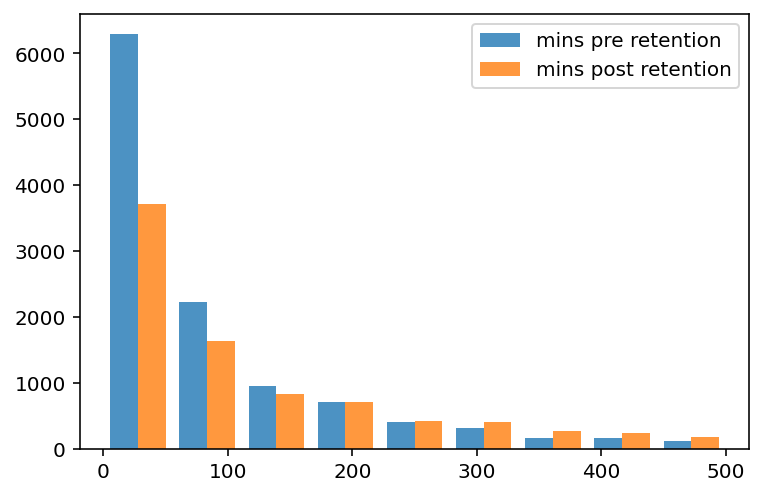

In [124]:
x = df_user_overview.pre_time_spent_in_book_m_rounded
y = df_user_overview.post_time_spent_in_book_m_rounded

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 500, 10)

plt.hist([x, y] , bins, alpha=0.8, label=['mins pre retention', 'mins post retention'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
plt.legend(loc='upper right')
plt.show()

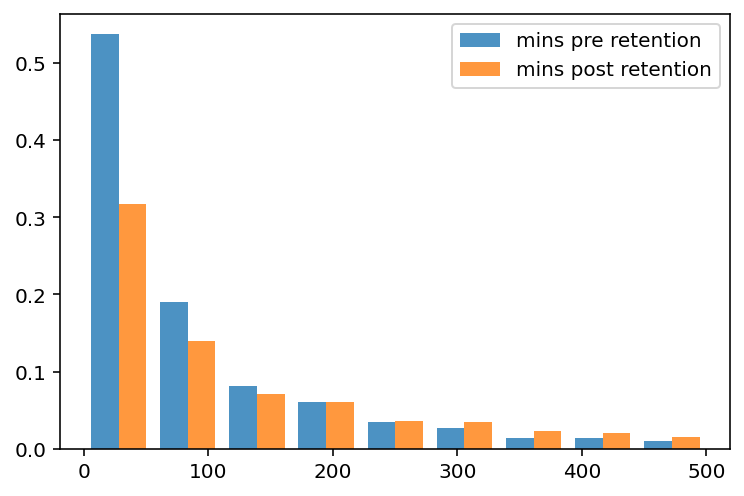

In [125]:
x = df_user_overview.pre_time_spent_in_book_m_rounded
y = df_user_overview.post_time_spent_in_book_m_rounded

# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 500, 10)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['mins pre retention', 'mins post retention'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
plt.legend(loc='upper right')
plt.show()

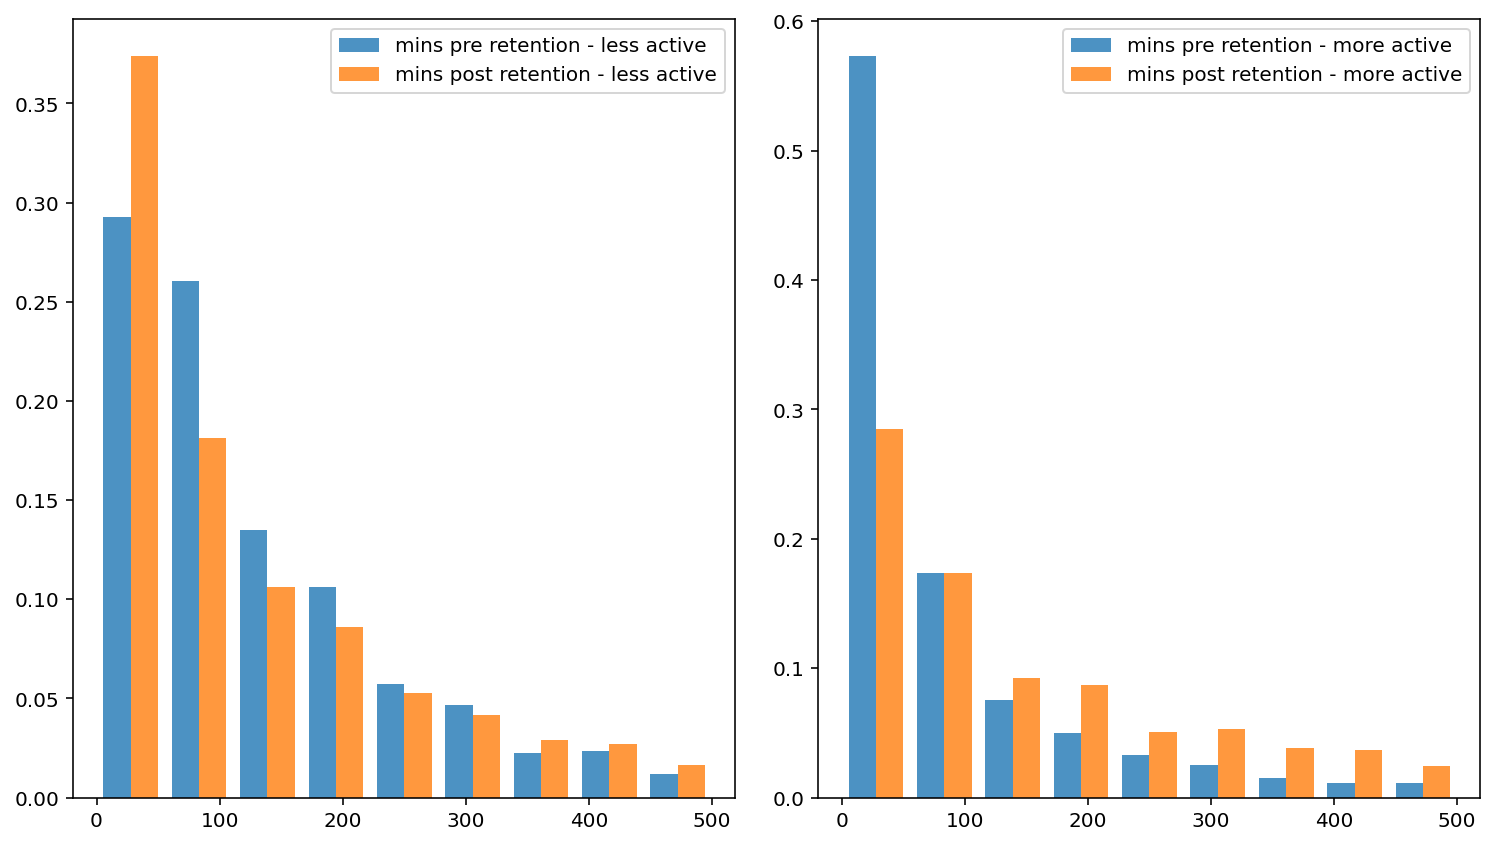

In [126]:
x1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].pre_time_spent_in_book_m_rounded
y1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].post_time_spent_in_book_m_rounded
# normalise
x1_w = np.empty(x1.shape)
x1_w.fill(1/x1.shape[0])
y1_w = np.empty(y1.shape)
y1_w.fill(1/y1.shape[0])


x2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].pre_time_spent_in_book_m_rounded
y2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].post_time_spent_in_book_m_rounded
# normalise
x2_w = np.empty(x2.shape)
x2_w.fill(1/x2.shape[0])
y2_w = np.empty(y2.shape)
y2_w.fill(1/y2.shape[0])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(10.5, 6)
plt.tight_layout()

bins = np.linspace(0, 500, 10)

ax1.hist([x1, y1] , bins, weights=[x1_w, y1_w], alpha=0.8, label=['mins pre retention - less active', 'mins post retention - less active'])
ax2.hist([x2, y2] , bins, weights=[x2_w, y2_w], alpha=0.8, label=['mins pre retention - more active', 'mins post retention - more active'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

We can see the distribution really changes when comparing those more active versus left.

You don't need lots of minutes before retaining, but afterwards there's likely to be a much strong long tail.

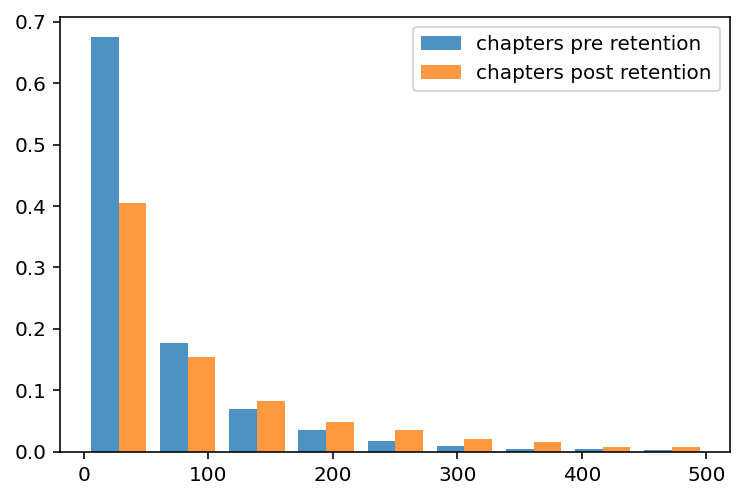

In [127]:
x = df_user_overview.pre_chapters_opened
y = df_user_overview.post_chapters_opened

# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 500, 10)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['chapters pre retention', 'chapters post retention'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
plt.legend(loc='upper right')
plt.show()

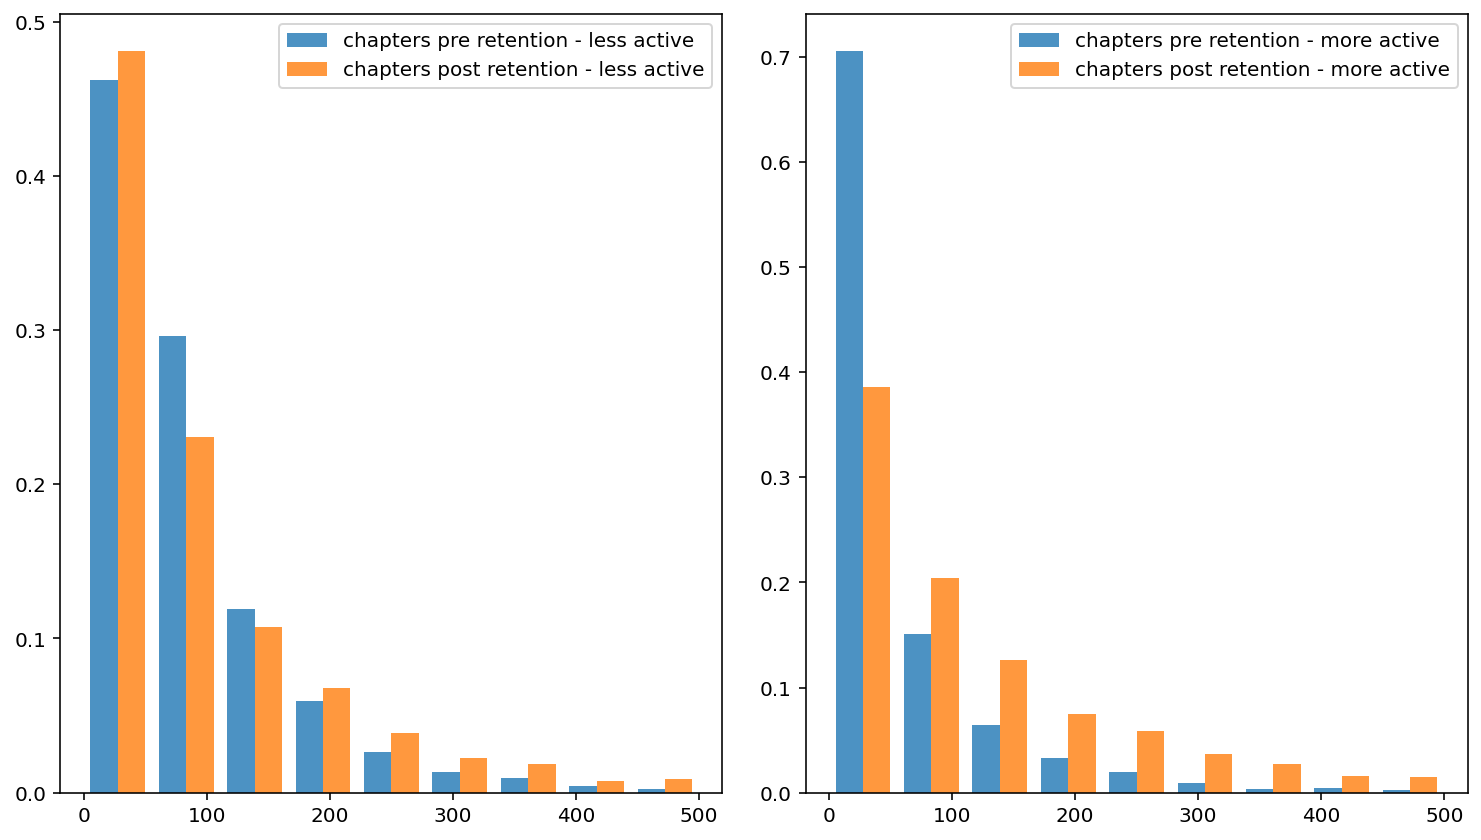

In [128]:
x1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].pre_chapters_opened
y1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].post_chapters_opened
# normalise
x1_w = np.empty(x1.shape)
x1_w.fill(1/x1.shape[0])
y1_w = np.empty(y1.shape)
y1_w.fill(1/y1.shape[0])


x2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].pre_chapters_opened
y2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].post_chapters_opened
# normalise
x2_w = np.empty(x2.shape)
x2_w.fill(1/x2.shape[0])
y2_w = np.empty(y2.shape)
y2_w.fill(1/y2.shape[0])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(10.5, 6)
plt.tight_layout()

bins = np.linspace(0, 500, 10)

ax1.hist([x1, y1] , bins, weights=[x1_w, y1_w], alpha=0.8, label=['chapters pre retention - less active', 'chapters post retention - less active'])
ax2.hist([x2, y2] , bins, weights=[x2_w, y2_w], alpha=0.8, label=['chapters pre retention - more active', 'chapters post retention - more active'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

Again, depth seems to trump depth.

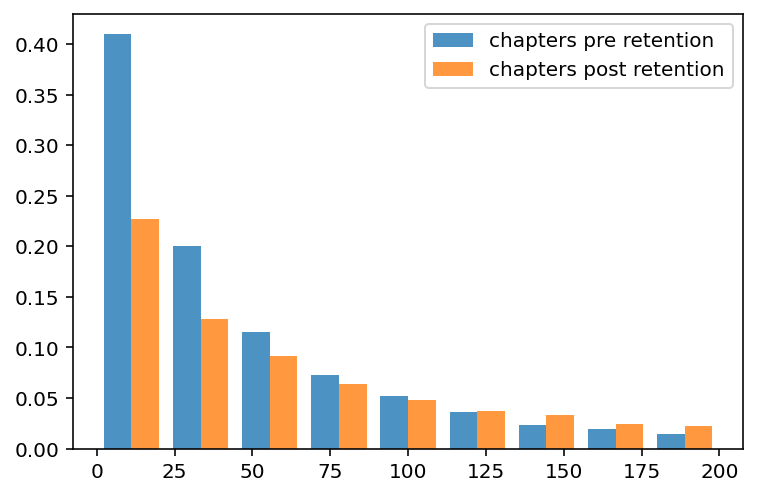

In [129]:
x = df_user_overview.pre_chapters_opened
y = df_user_overview.post_chapters_opened

# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 200, 10)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['chapters pre retention', 'chapters post retention'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
plt.legend(loc='upper right')
plt.show()

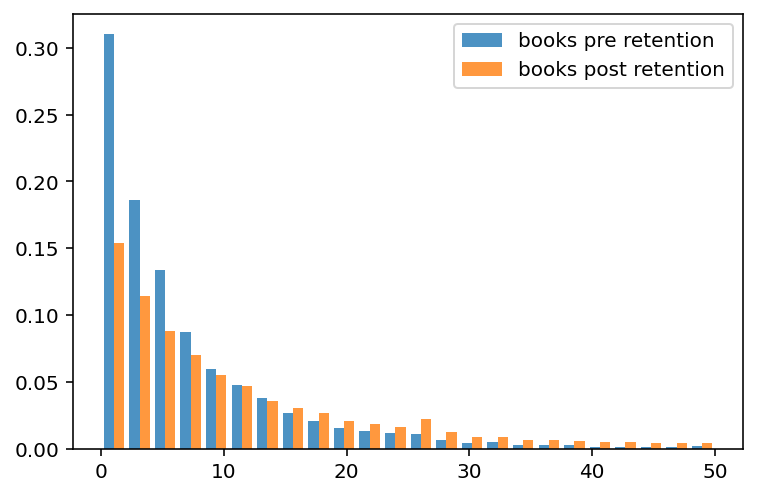

In [130]:
x = df_user_overview.pre_books
y = df_user_overview.post_books

# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 50, 25)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['books pre retention', 'books post retention'])
plt.legend(loc='upper right')
plt.show()

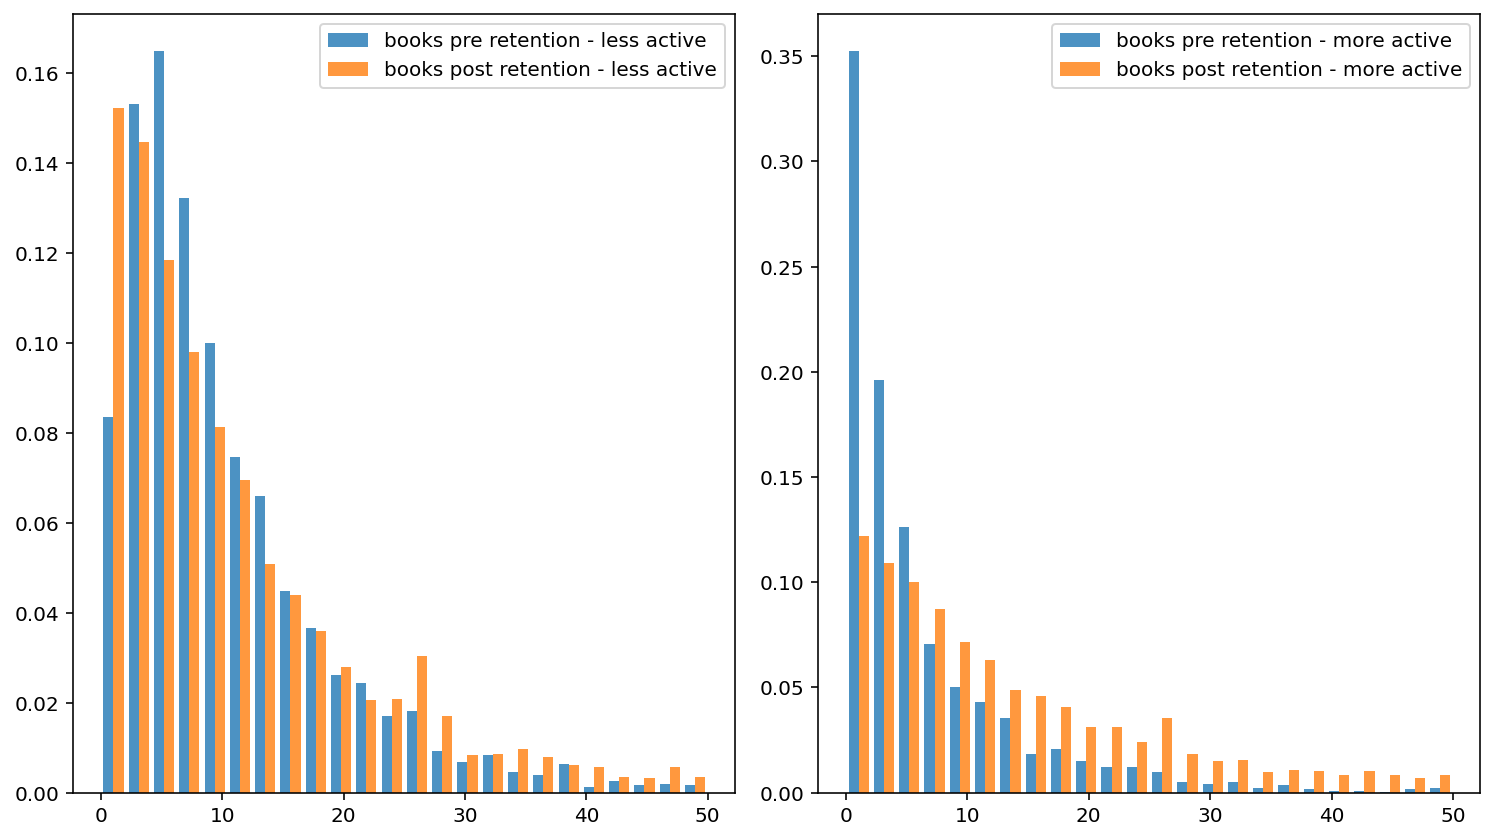

In [131]:
x1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].pre_books
y1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].post_books
# normalise
x1_w = np.empty(x1.shape)
x1_w.fill(1/x1.shape[0])
y1_w = np.empty(y1.shape)
y1_w.fill(1/y1.shape[0])


x2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].pre_books
y2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].post_books
# normalise
x2_w = np.empty(x2.shape)
x2_w.fill(1/x2.shape[0])
y2_w = np.empty(y2.shape)
y2_w.fill(1/y2.shape[0])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(10.5, 6)
plt.tight_layout()

bins = np.linspace(0, 50, 25)

ax1.hist([x1, y1] , bins, weights=[x1_w, y1_w], alpha=0.8, label=['books pre retention - less active', 'books post retention - less active'])
ax2.hist([x2, y2] , bins, weights=[x2_w, y2_w], alpha=0.8, label=['books pre retention - more active', 'books post retention - more active'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

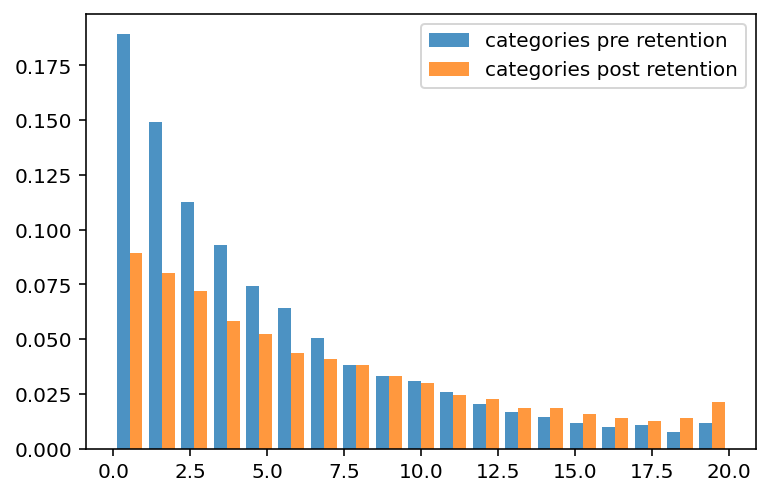

In [132]:
x = df_user_overview.pre_catgories  # typo
y = df_user_overview.post_catgories

# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 20, 20)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['categories pre retention', 'categories post retention'])
plt.legend(loc='upper right')
plt.show()

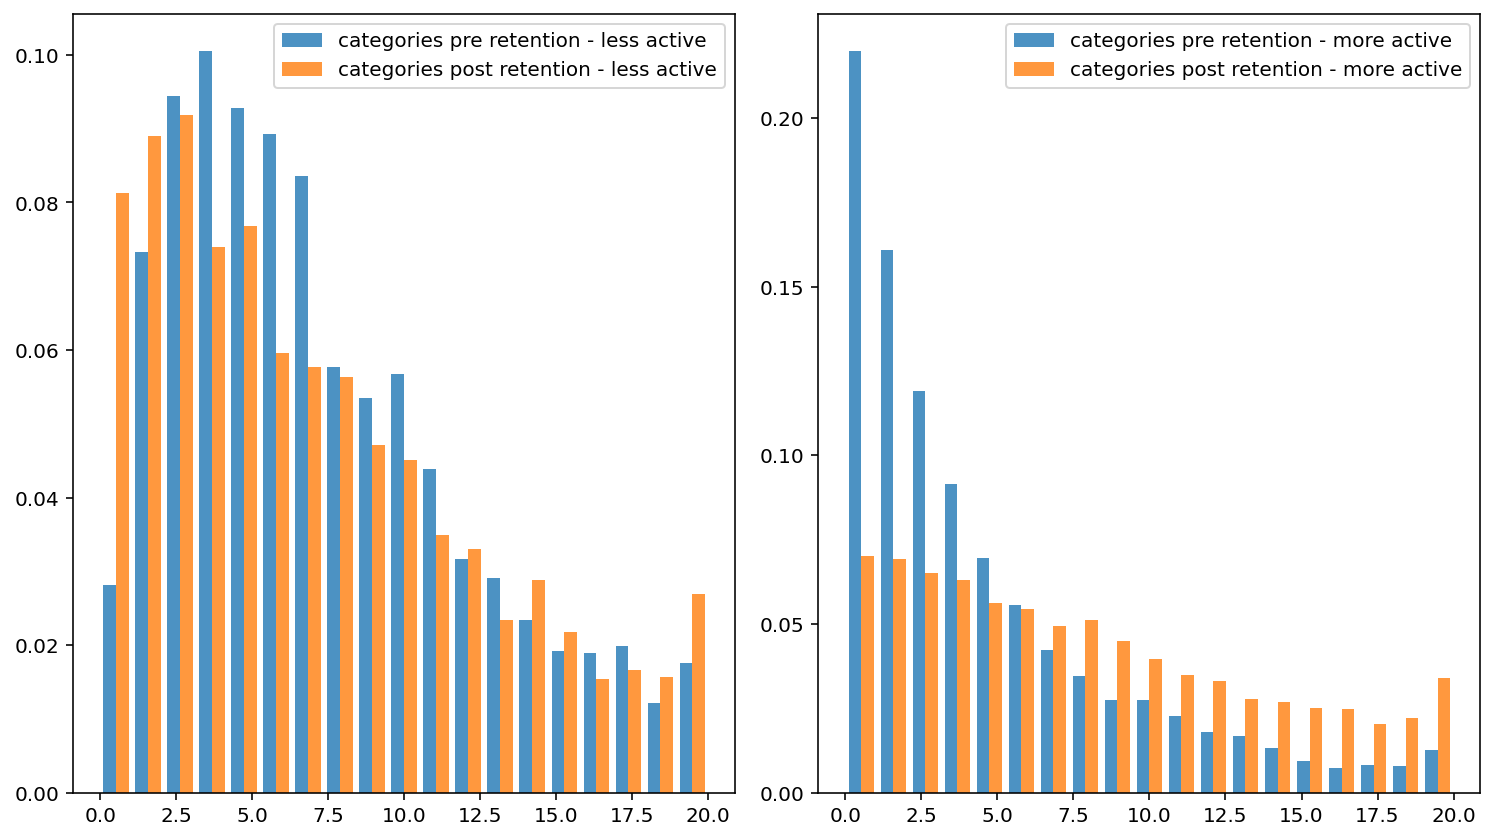

In [133]:
x1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].pre_catgories
y1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].post_catgories
# normalise
x1_w = np.empty(x1.shape)
x1_w.fill(1/x1.shape[0])
y1_w = np.empty(y1.shape)
y1_w.fill(1/y1.shape[0])


x2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].pre_catgories
y2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].post_catgories
# normalise
x2_w = np.empty(x2.shape)
x2_w.fill(1/x2.shape[0])
y2_w = np.empty(y2.shape)
y2_w.fill(1/y2.shape[0])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(10.5, 6)
plt.tight_layout()

bins = np.linspace(0, 20, 20)

ax1.hist([x1, y1] , bins, weights=[x1_w, y1_w], alpha=0.8, label=['categories pre retention - less active', 'categories post retention - less active'])
ax2.hist([x2, y2] , bins, weights=[x2_w, y2_w], alpha=0.8, label=['categories pre retention - more active', 'categories post retention - more active'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

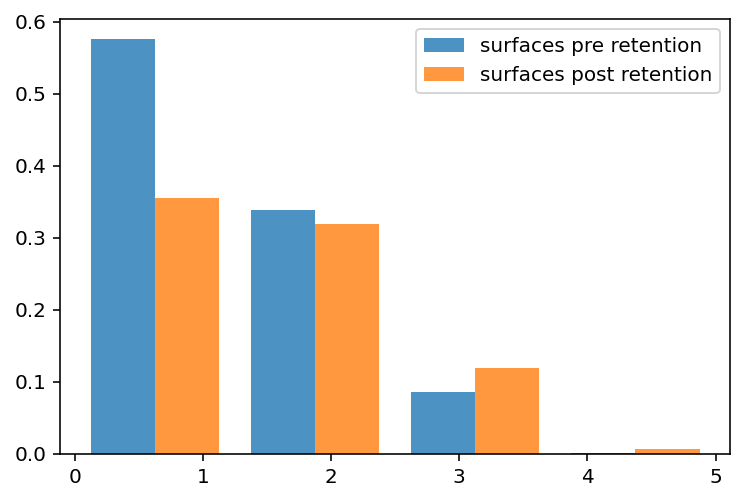

In [134]:
x = df_user_overview.pre_surfaces
y = df_user_overview.post_surfaces

# normalise
x_w = np.empty(x.shape)
x_w.fill(1/x.shape[0])
y_w = np.empty(y.shape)
y_w.fill(1/y.shape[0])

fig = plt.figure()
plt.tight_layout()
bins = np.linspace(0, 5, 5)

plt.hist([x, y] , bins, weights=[x_w, y_w], alpha=0.8, label=['surfaces pre retention', 'surfaces post retention'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
plt.legend(loc='upper right')
plt.show()

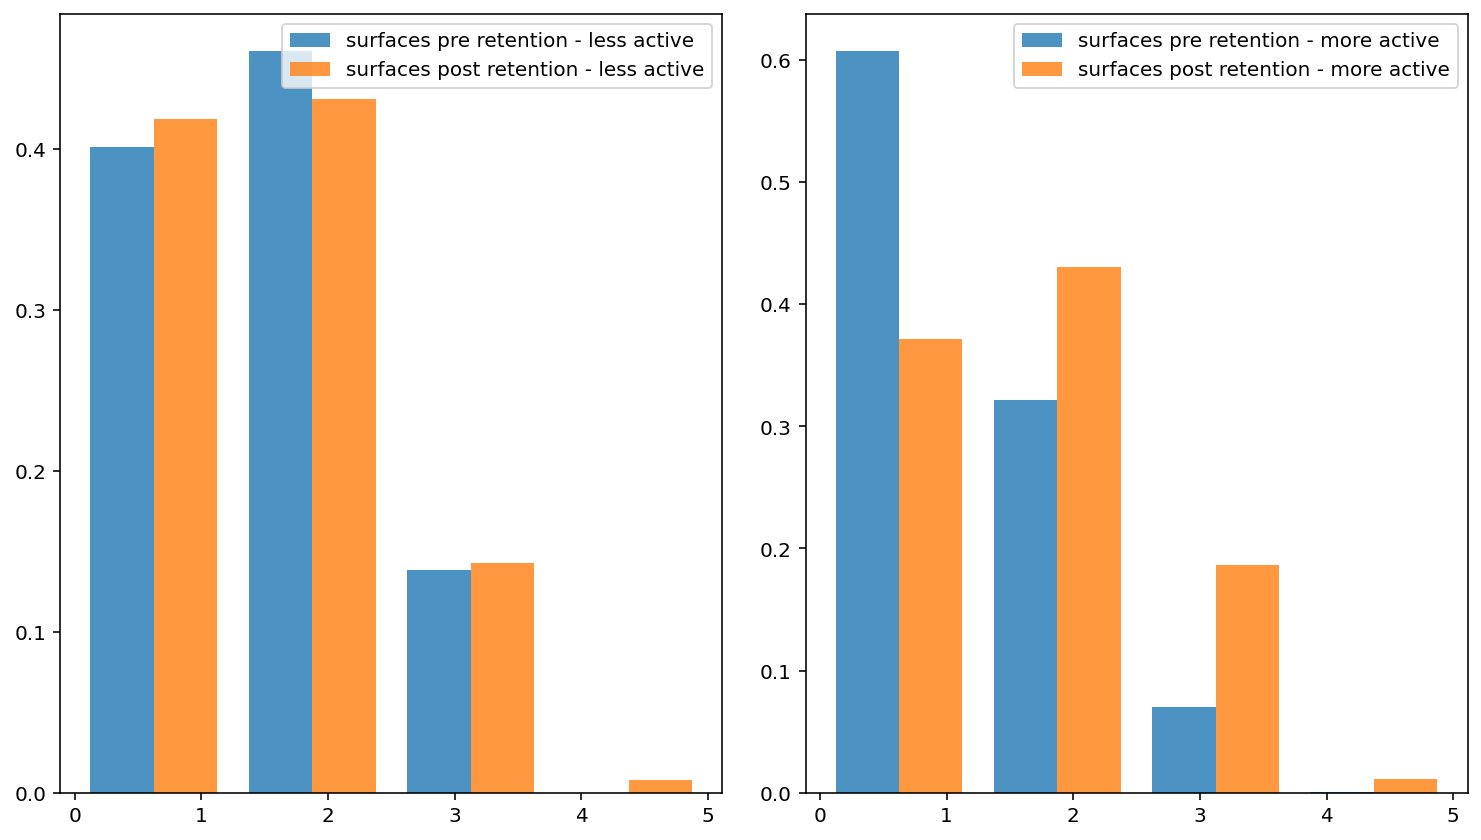

In [135]:
x1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].pre_surfaces
y1 = df_user_overview[df_user_overview.is_more_or_same_active == 0].post_surfaces
# normalise
x1_w = np.empty(x1.shape)
x1_w.fill(1/x1.shape[0])
y1_w = np.empty(y1.shape)
y1_w.fill(1/y1.shape[0])


x2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].pre_surfaces
y2 = df_user_overview[df_user_overview.is_more_or_same_active == 1].post_surfaces
# normalise
x2_w = np.empty(x2.shape)
x2_w.fill(1/x2.shape[0])
y2_w = np.empty(y2.shape)
y2_w.fill(1/y2.shape[0])

f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(10.5, 6)
plt.tight_layout()

bins = np.linspace(0, 5, 5)

ax1.hist([x1, y1] , bins, weights=[x1_w, y1_w], alpha=0.8, label=['surfaces pre retention - less active', 'surfaces post retention - less active'])
ax2.hist([x2, y2] , bins, weights=[x2_w, y2_w], alpha=0.8, label=['surfaces pre retention - more active', 'surfaces post retention - more active'])
# plt.hist(post_mins, bins, alpha=0.5, label='mins post retention')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.show()

In [136]:
# are there particular books or categories that really stand out?